In [1]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
from ebm.model import Network
import networkx as nx
from ebm.external_world import ExternalWorld, MNISTExternalWorld

from ebm.train_model import *


def pi(s):
    return torch.clamp(s, 0.0, 1.0)

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)



In [2]:
def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 5, dtype=int)
    # with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
    for epoch in range(epochs):
        for i in range(n_batches):
            if(i>0):
                for j in range(0,len(net.layers)):

                    net.layers[j] = 0 * net.layers[j]
            net.biases[-1] *=0
            net.weights[-1] = torch.tensor([[-1.,1.]]) 
            for j in range(0,len(net.persistent_particles)):
                net.persistent_particles[j] = net.persistent_particles[j] * 0 
            net.update_mini_batch_index(i)
            net.negative_phase(n_it_neg)
            net.positive_phase(n_it_pos, *alphas)

            # for j in range(0,len(net.biases)-2):
            #     net.biases[j]*= 0 
            net.biases[-1] *=0
            net.weights[-1] = torch.tensor([[-1.,1.]]) 
            for j in range(0,len(net.persistent_particles)):
                net.persistent_particles[j] = net.persistent_particles[j] * 0 
            # for j in range

            # net.persistent_particles *=0
            
            # = [
            #     torch.tensor([[-1.,  1.],
            #                 [ 1., -1.]]),           # Input → Hidden
            #     torch.tensor([[1.],
            #                 [1.]]),            # Hidden → Output
            #     torch.tensor([[-1.,1.]])    # Final classifier layer (if used)
            # ]


        # Measure and log
        E, C, error = net.measure()
        history["Energy"].append(E)
        history["Cost"].append(C)
        history["Error"].append(error * 100)

        # Update progress bar description instead of using set_postfix()
        # epoch_bar.set_description(f"Epoch {epoch+1}/{epochs} | E={E:.2f} C={C:.5f} Error={error*100:.2f}%")
        # epoch_bar.update(1)
        if(plot_graph):
            if epoch in snapshot_epochs:
                if(history["Error"][-1]< 0.001):
                    plot_network_weights(net, epoch)
    # Plot results
    res = np.mean(history["Error"][-4:])
    if(plot_graph and res < 0.001):
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
            ax.plot(history[key], label=key, color=color)
            ax.set_title(f"{key} over Epochs")
        plt.tight_layout()
        plt.show()
    return res

In [3]:
import torch.nn as nn
# XOR dataset
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
xor_y = np.array([0, 1, 1, 0], dtype=np.int64)

# ExternalWorld instance with XOR data
xor_world = ExternalWorld(xor_x, xor_y)


  0%|          | 0/64 [00:00<?, ?it/s]

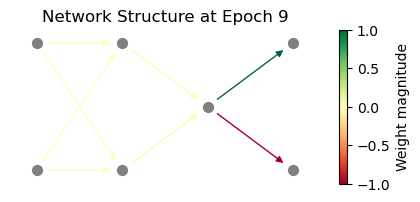

 22%|██▏       | 14/64 [00:00<00:00, 99.58it/s]

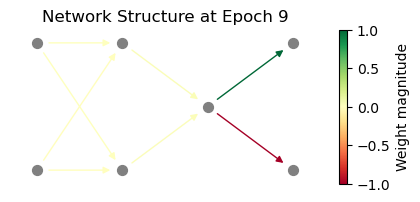

 38%|███▊      | 24/64 [00:00<00:00, 61.50it/s]

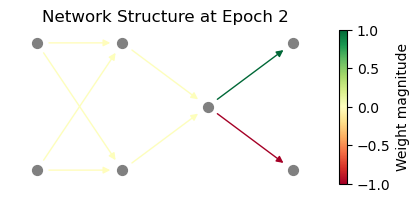

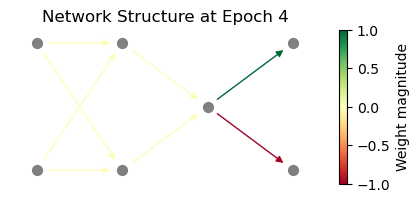

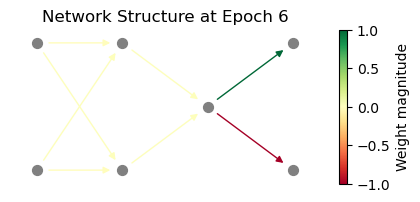

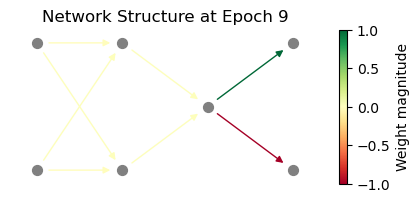

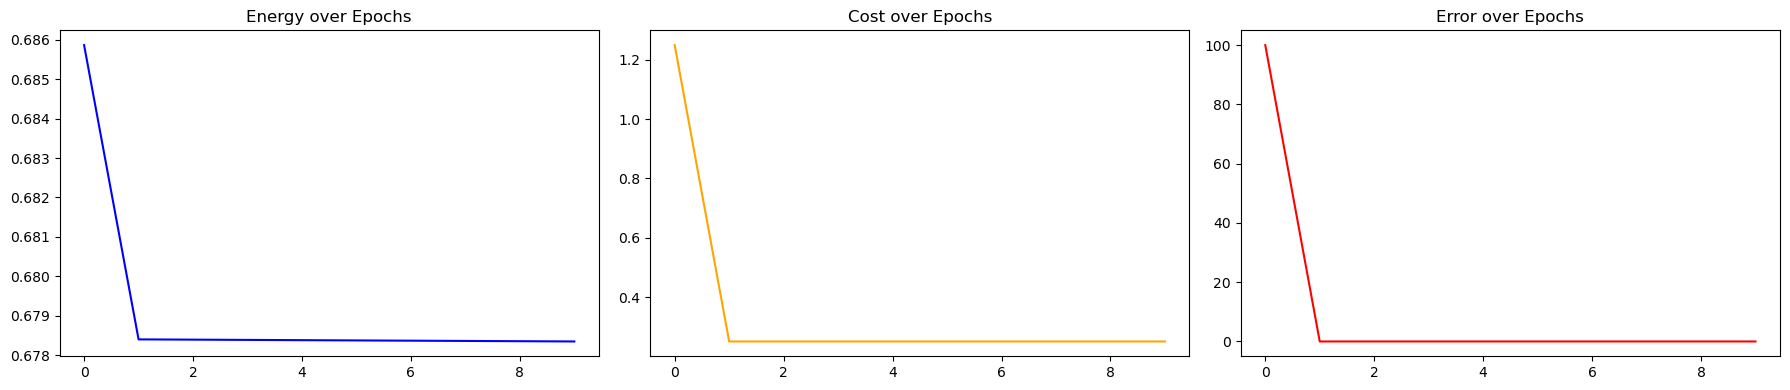

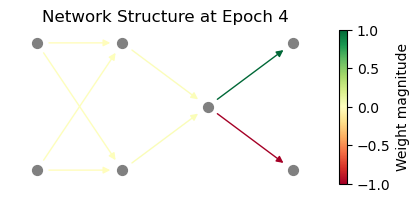

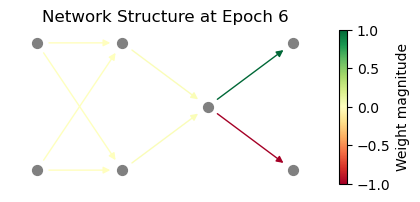

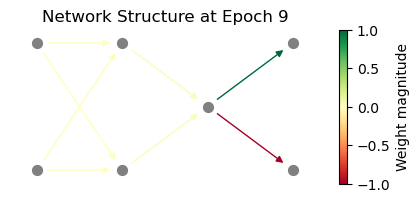

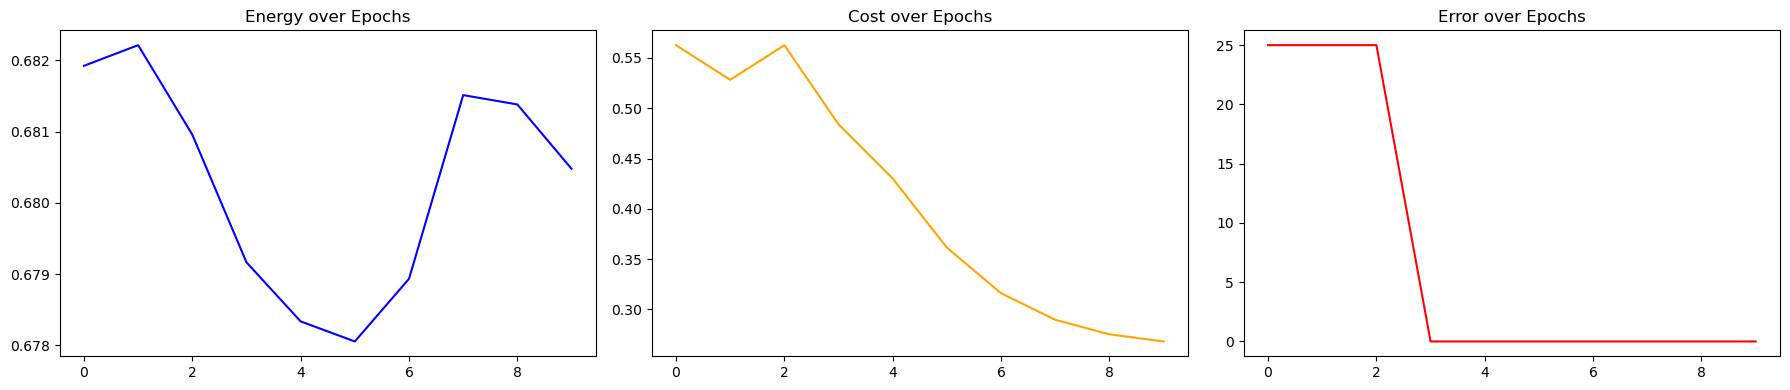

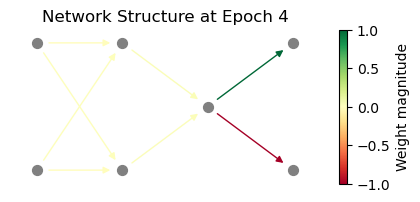

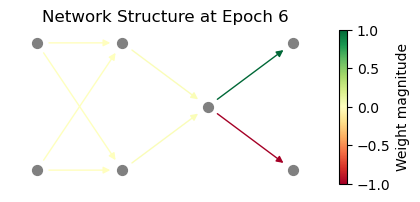

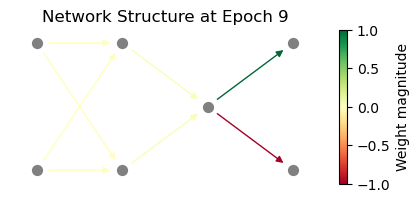

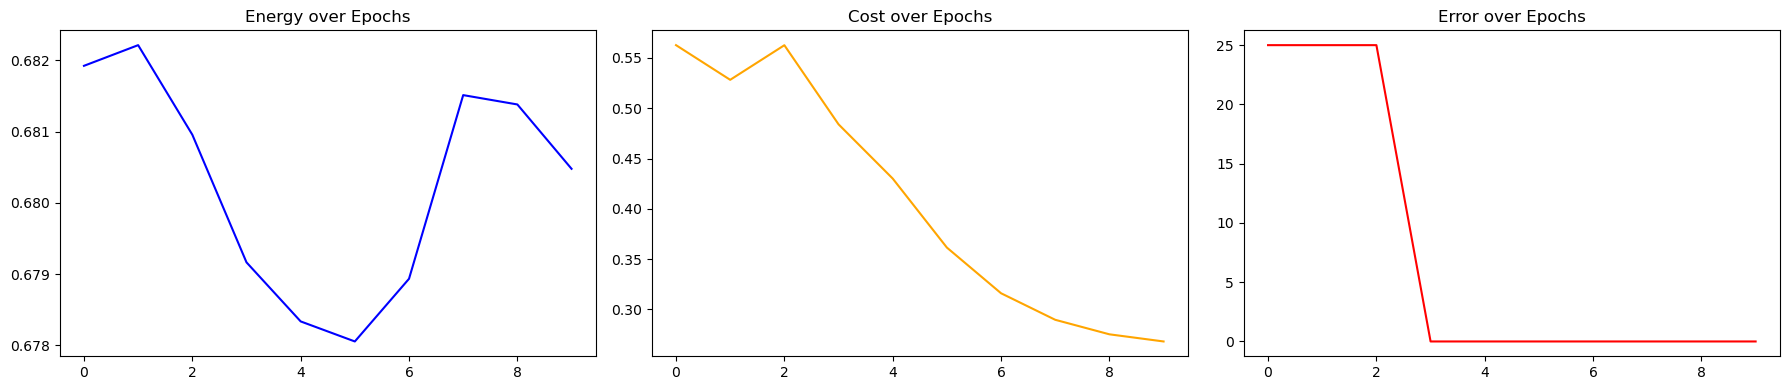

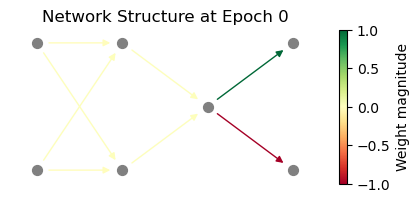

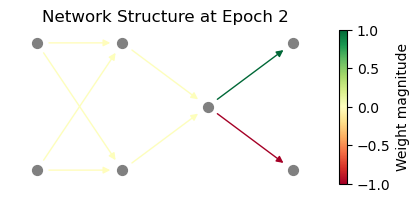

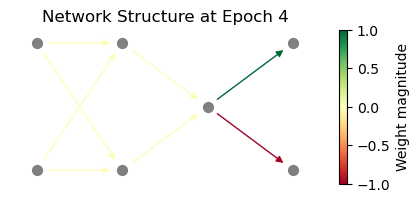

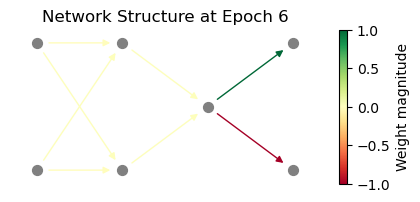

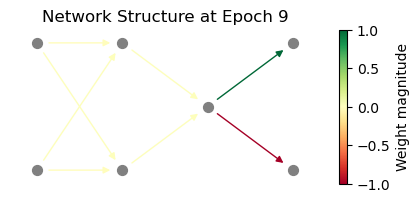

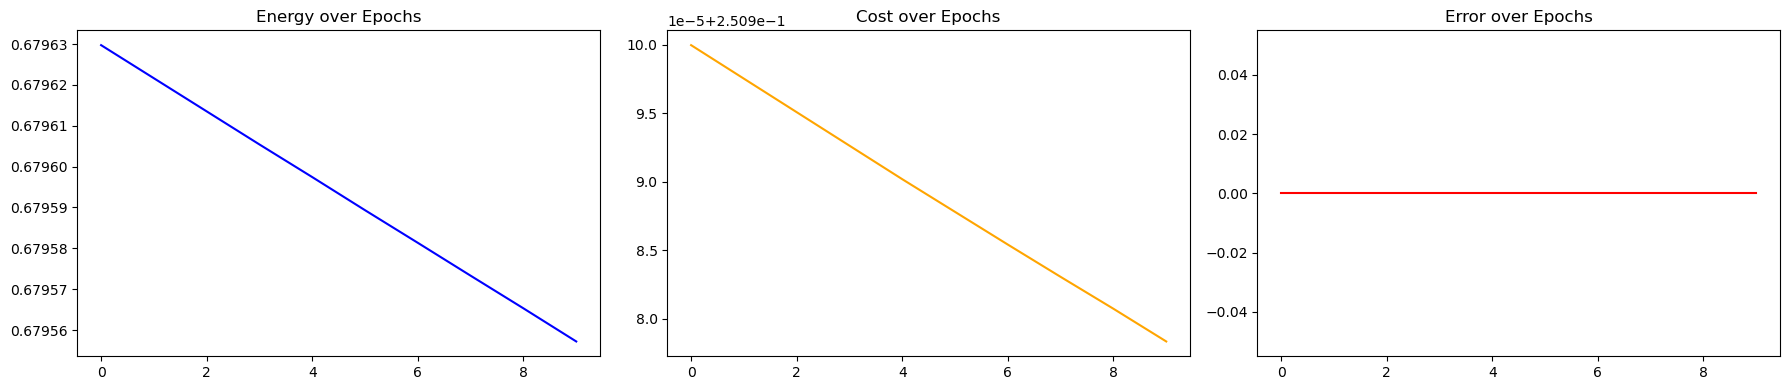

 48%|████▊     | 31/64 [00:01<00:02, 13.77it/s]

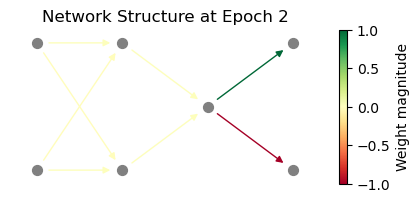

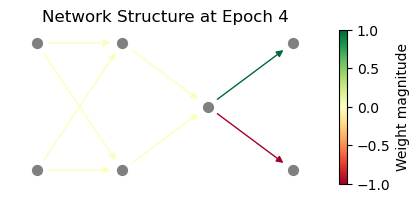

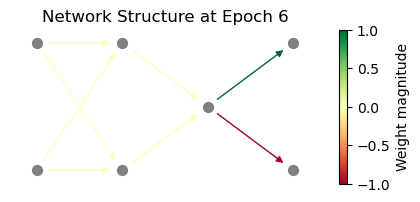

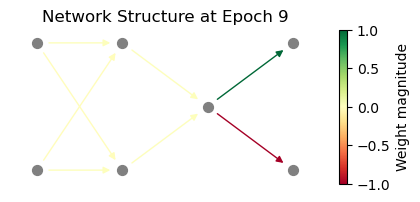

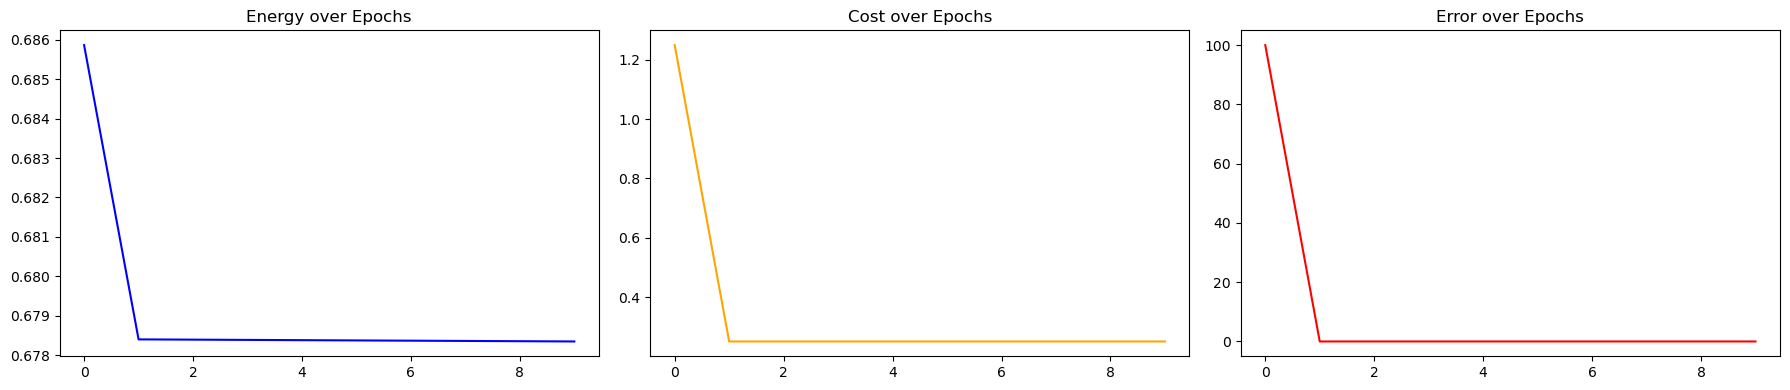

 58%|█████▊    | 37/64 [00:02<00:01, 13.88it/s]

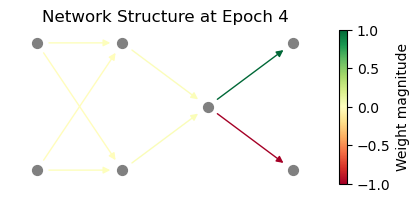

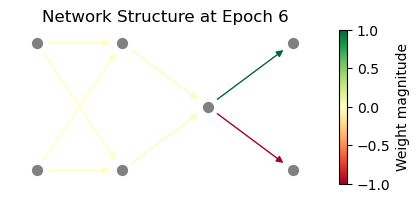

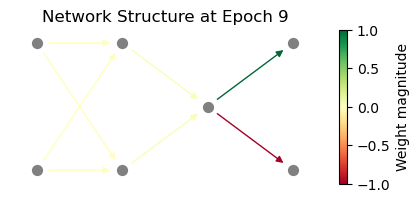

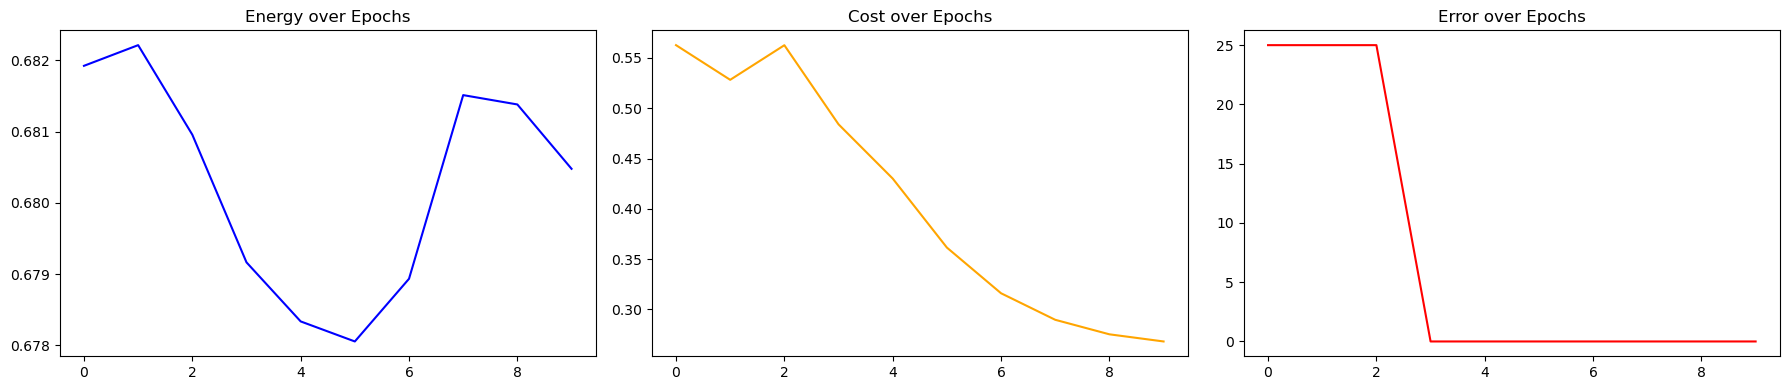

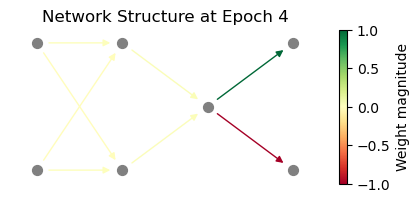

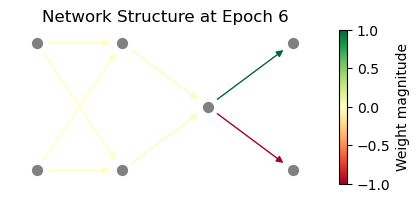

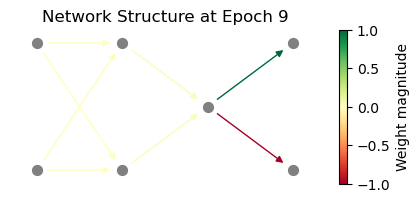

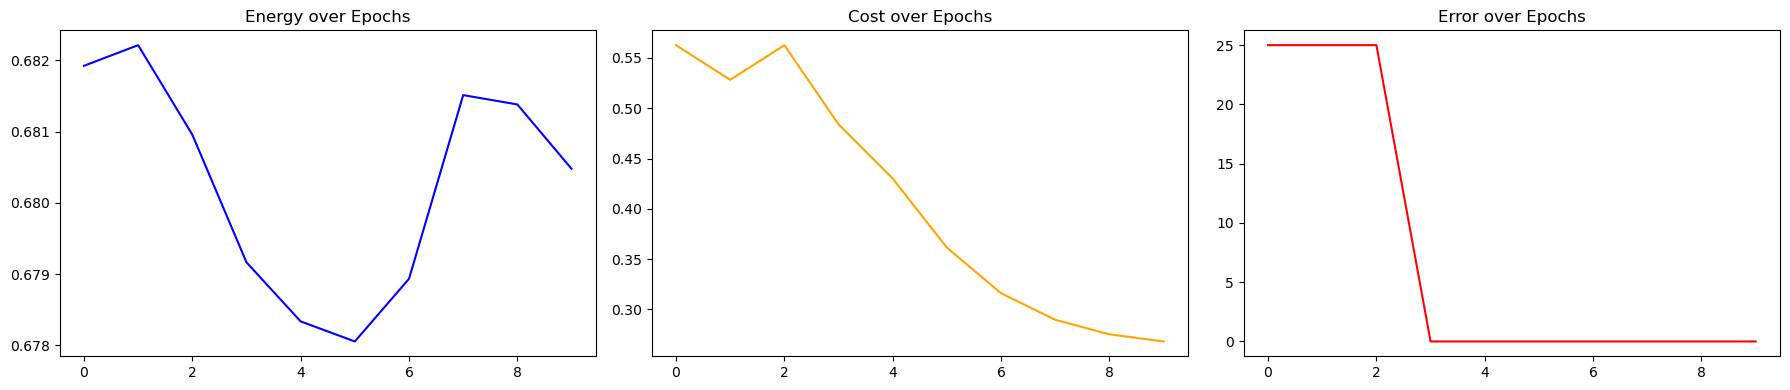

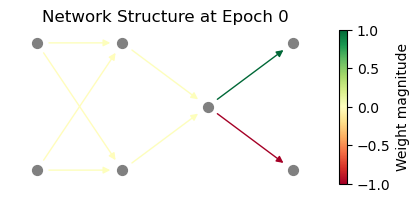

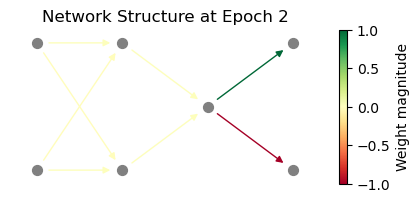

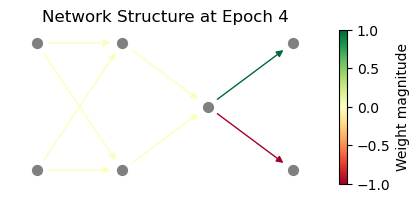

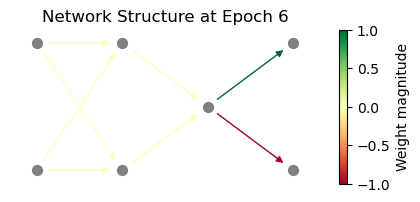

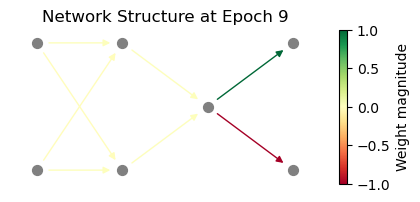

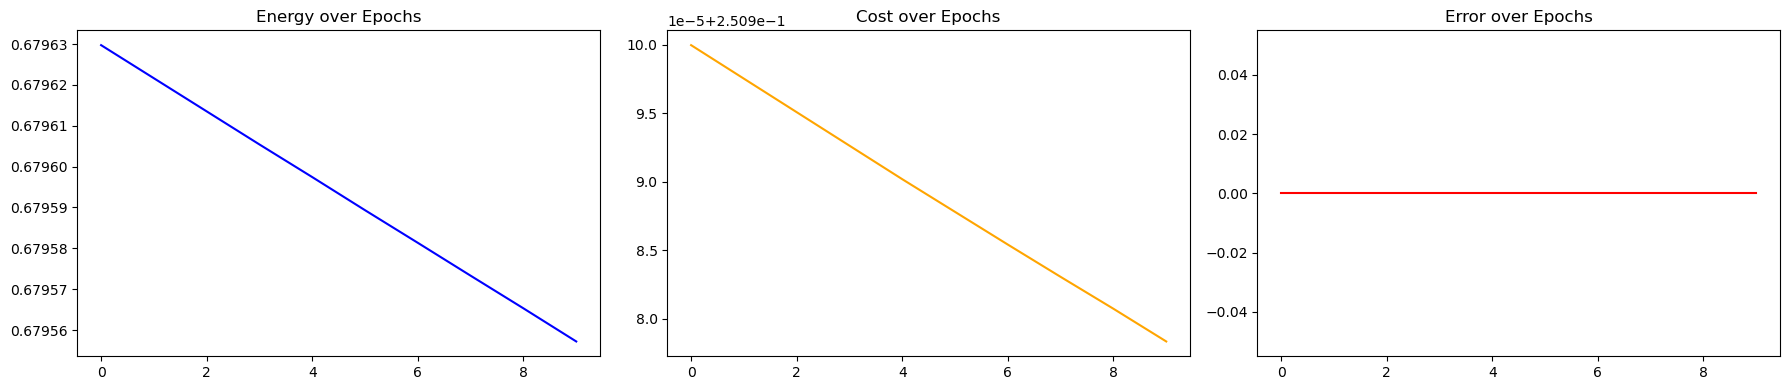

 62%|██████▎   | 40/64 [00:03<00:02,  8.57it/s]

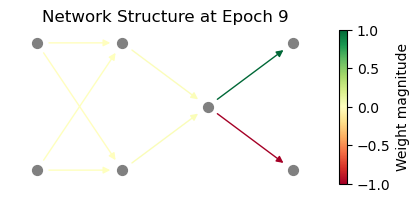

 78%|███████▊  | 50/64 [00:03<00:00, 14.40it/s]

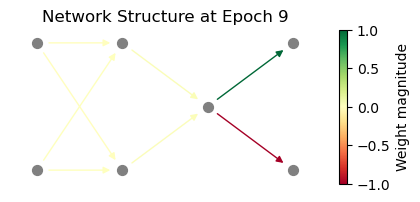

100%|██████████| 64/64 [00:03<00:00, 19.40it/s]


In [4]:
import itertools
import numpy as np
import torch

# Generate all possible combinations of -1, 0, 1 for 9 parameters
all_inits = list(itertools.product([-0.01,0.01], repeat=6))

results = []


errors = {}

lst = [a for a in enumerate(all_inits)]

for i, init in tqdm(lst):
    trials = 1
    error_counter = 0 
    for t in range(0, trials):
        xor_net = Network(
            name=f"xor_trial_{i}",
            external_world=xor_world,
            hyperparameters={
                "hidden_sizes": [2, 1],
                "output_size": 2,
                "batch_size": 4,
                "n_epochs": 10,  # just test untrained net
                "n_it_neg": 1,
                "n_it_pos": 1,
                "alphas": [0.1, 0.1, 0.1],
                "activation": "relu"
            }
        )

        # Unpack init into weights and biases
        init = torch.tensor(init, dtype=torch.float32)
        W0 = init[:4].reshape(2, 2)
        # b1 = init[4:6]
        W1 = init[4:6].reshape(2, 1)
        # b2 = init[8:]

        with torch.no_grad():
            xor_net.weights[0][:] = W0
            # xor_net.biases[1][:] = b1
            xor_net.weights[1][:] = W1
            # xor_net.biases[2][:] = b2

        # print(init)

        # Evaluate the net — assume this function exists
        error_counter+= train_net(xor_net, plot_graph= True)

    errors[init] = (error_counter / trials, xor_net.weights[0][:] , xor_net.weights[1][:], xor_net.weights, xor_net.biases, xor_net.persistent_particles)
    # print(xor_net.biases)
    # print(xor_net.weights)

    # results.append((i, acc.item(), init.numpy()))


In [5]:
zero_error_weights = torch.stack([k for k in errors if errors[k][0] < 0.001])

zero_error_weights

tensor([[-0.0100,  0.0100,  0.0100, -0.0100, -0.0100, -0.0100],
        [-0.0100,  0.0100,  0.0100, -0.0100, -0.0100,  0.0100],
        [-0.0100,  0.0100,  0.0100, -0.0100,  0.0100, -0.0100],
        [-0.0100,  0.0100,  0.0100, -0.0100,  0.0100,  0.0100],
        [ 0.0100, -0.0100, -0.0100,  0.0100, -0.0100, -0.0100],
        [ 0.0100, -0.0100, -0.0100,  0.0100, -0.0100,  0.0100],
        [ 0.0100, -0.0100, -0.0100,  0.0100,  0.0100, -0.0100],
        [ 0.0100, -0.0100, -0.0100,  0.0100,  0.0100,  0.0100]])

In [6]:
import torch

def relu(x):
    return max(0.0, x)

def weights_to_formula_and_check(w):
    """
    Given 6D weight tensor, return:
    - ReLU formula string
    - Evaluation on all 4 (x1, x2) inputs
    - Whether it implements XOR, XNOR, or neither
    """
    w1, w2, w3, w4, w5, w6 = [float(x) for x in w]

    # Print formula
    formula = [
        f"h1 = ReLU({w2:.2f} * x1 + {w4:.2f} * x2)",
        f"h2 = ReLU({w1:.2f} * x1 + {w3:.2f} * x2)",
        f"y  = {w6:.2f} * h1 + {w5:.2f} * h2"
    ]

    results = {}
    for x1 in [0, 1]:
        for x2 in [0, 1]:
            h1 = relu(w2 * x1 + w4 * x2)
            h2 = relu(w1 * x1 + w3 * x2)
            y = w6 * h1 + w5 * h2
            results[(x1, x2)] = y
            print(x1, x2, results[(x1,x2)])

    # Expected values
    xor = {(0,0): 0, (0,1): 1, (1,0): 1, (1,1): 0}
    xnor = {k: 1 - v for k, v in xor.items()}

    def match(truth):
        return all(abs(results[k] - truth[k]) <= 0.1 for k in results)

    if match(xor):
        verdict = "XOR"
    elif match(xnor):
        verdict = "XNOR"
    else:
        verdict = "Neither"

    return formula + [results] + [verdict]


In [7]:
f_weights = []

for initial_weights, (final_error, w_in, w_out, wall, ball, pp) in [(k, errors[k]) for k in errors if errors[k][0] < 0.001]:
    w_in = w_in.numpy()
    w_out = w_out.numpy()

    final_weights = np.concatenate([w_in.flatten(), w_out.flatten()])
    f_weights.append((final_weights, wall, ball))

In [8]:


for wt in f_weights:
    w = wt[0]
    print()
    result = weights_to_formula_and_check(w)
    for r in result:
        print(r)
    print("weights", w)
    # print(w)
    print("all weights", wall)
    print("bias", ball)
    print("pers particles", pp)


0 0 0.0
0 1 0.00015152271262355854
1 0 0.00015152271262355854
1 1 0.0
h1 = ReLU(0.01 * x1 + -0.01 * x2)
h2 = ReLU(-0.01 * x1 + 0.01 * x2)
y  = 0.02 * h1 + 0.02 * h2
{(0, 0): 0.0, (0, 1): 0.00015152271262355854, (1, 0): 0.00015152271262355854, (1, 1): 0.0}
Neither
weights [-0.01003563  0.01003563  0.01003563 -0.01003563  0.01509847  0.01509847]
all weights [tensor([[ 0.0100, -0.0100],
        [-0.0100,  0.0100]]), tensor([[0.0102],
        [0.0102]]), tensor([[-1.,  1.]])]
bias [tensor([0., 0.]), tensor([-3.7253e-10, -3.7253e-10]), tensor([0.]), tensor([0., 0.])]
pers particles [tensor([[-0., -0.],
        [-0., 0.],
        [0., -0.],
        [-0., -0.]]), tensor([[-0.],
        [0.],
        [0.],
        [-0.]]), tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

0 0 0.0
0 1 0.0002884197249813994
1 0 0.0
1 1 0.0
h1 = ReLU(-0.01 * x1 + 0.01 * x2)
h2 = ReLU(-0.00 * x1 + 0.00 * x2)
y  = 0.03 * h1 + 0.03 * h2
{(0, 0): 0.0, (0, 1): 0.0002884197249813994, (1, 0): 0

In [9]:
errors

{tensor([-0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100]): (100.0,
  tensor([[-0.1348, -0.1348],
          [-0.1348, -0.1348]]),
  tensor([[-0.0100],
          [-0.0100]]),
  [tensor([[-0.1348, -0.1348],
           [-0.1348, -0.1348]]),
   tensor([[-0.0100],
           [-0.0100]]),
   tensor([[-1.,  1.]])],
  [tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0., 0.])],
  [tensor([[0., 0.],
           [0., 0.],
           [0., 0.],
           [0., 0.]]),
   tensor([[0.],
           [0.],
           [0.],
           [0.]]),
   tensor([[0., 0.],
           [0., 0.],
           [0., 0.],
           [0., 0.]])]),
 tensor([-0.0100, -0.0100, -0.0100, -0.0100, -0.0100,  0.0100]): (100.0,
  tensor([[-0.1348, -0.0100],
          [-0.1348, -0.0100]]),
  tensor([[-0.0100],
          [ 0.0100]]),
  [tensor([[-0.1348, -0.0100],
           [-0.1348, -0.0100]]),
   tensor([[-0.0100],
           [ 0.0100]]),
   tensor([[-1.,  1.]])],
  [tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), t

In [10]:
import torch
import pandas as pd
import numpy as np

# Prepare data for DataFrame
data_rows = []

for initial_weights, (final_error, w_in, w_out) in [(k, errors[k]) for k in errors if errors[k][0] < 0.001]:
    w_in = w_in.numpy()
    w_out = w_out.numpy()

    final_weights = np.concatenate([w_in.flatten(), w_out.flatten()])

    # Thresholding to {-1, 0, 1}
    thresholded = np.zeros_like(final_weights)
    thresholded[final_weights > 0.0005] = 1
    thresholded[final_weights < -0.0005] = -1

    def oppose(a, b):
        return np.sign(a) != np.sign(b) and a != 0 and b != 0

    row = {
        'final_error': final_error,
    }

    for i in range(6):
        row[f'initial_w{i}'] = initial_weights[i].item()
        row[f'final_w{i}'] = final_weights[i]
        row[f'thresh_w{i}'] = thresholded[i]

    # All pairwise oppositions among w0–w5
    for i in range(6):
        for j in range(i+1, 6):
            row[f'opp_{i}{j}'] = oppose(final_weights[i], final_weights[j])

    data_rows.append(row)

df_weights = pd.DataFrame(data_rows)

df_weights

ValueError: too many values to unpack (expected 3)

In [54]:
def plot_energy_graph_per_sample(net: Network, sample_indices=[0, 1, 2, 3]):
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']
    layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
    total_layers = len(layer_sizes)

    for sample_idx in sample_indices:
        G = nx.DiGraph()
        sample_activations = [layer[sample_idx] for layer in net.layers]
        sample_energy = 0

        # Add nodes
        for i, layer_size in enumerate(layer_sizes):
            for n in range(layer_size):
                node_label = f"{layer_labels[i]}_{n}"
                bias = net.biases[i][n].item()
                activation = sample_activations[i][n].item()
                G.add_node((layer_labels[i], n), 
                           label=node_label, 
                           bias=bias, 
                           activation=activation, 
                           subset=i)

        edge_weights = []
        edge_contribs = []
        for idx, W in enumerate(net.weights):
            layer_from = layer_labels[idx]
            layer_to = layer_labels[idx + 1]
            from_act = sample_activations[idx]
            to_act = sample_activations[idx + 1]

            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    w_ij = W[i, j].item()
                    contrib = - from_act[i].item() * w_ij * to_act[j].item()
                    edge_contribs.append(contrib)
                    edge_weights.append(w_ij)
                    G.add_edge((layer_from, i), (layer_to, j), weight=w_ij, contrib=contrib)

        bias_energy = sum(-net.biases[i][n].item() * sample_activations[i][n].item()
                          for i in range(1, total_layers)
                          for n in range(layer_sizes[i]))
        energy_total = sum(edge_contribs) + bias_energy

        pos = nx.multipartite_layout(G, subset_key='subset')
        edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
        edge_contribs = np.array([G[u][v]['contrib'] for u, v in G.edges()])
        edge_norm = plt.Normalize(vmin=-np.max(np.abs(edge_weights)), vmax=np.max(np.abs(edge_weights)))

        # ⬇️ FIX: Use explicit figure and axis
        fig, ax = plt.subplots(figsize=(8, 4))

        edges = nx.draw_networkx_edges(
            G, pos, edge_color=edge_weights, edge_cmap=plt.cm.RdYlGn,
            edge_vmin=edge_norm.vmin, edge_vmax=edge_norm.vmax,
            arrows=True, arrowsize=10, ax=ax
        )

        node_colors = [G.nodes[n]['activation'] for n in G.nodes()]
        nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.coolwarm, node_size=300, ax=ax)

        node_labels = {n: f"{n[0]}_{n[1]}\nA={G.nodes[n]['activation']:.2f}\nB={G.nodes[n]['bias']:.2f}" for n in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7, ax=ax)

        sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=edge_norm)
        sm.set_array(edge_weights)
        fig.colorbar(sm, label='Weight Value', ax=ax)

        ax.set_title(f"Sample {sample_idx} | Total Energy: {energy_total:.4f}")
        ax.axis('off')
        plt.tight_layout()
        plt.show()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

def plot_energy_graph_per_sample_descriptive(net, sample_indices=[0, 1, 2, 3]):
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']
    layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
    total_layers = len(layer_sizes)

    for sample_idx in sample_indices:
        G = nx.DiGraph()
        sample_activations = [layer[sample_idx] for layer in net.layers]
        sample_particles = [p[sample_idx] for p in net.persistent_particles]
        edge_weights = []
        edge_contribs = []

        # Add nodes with bias and activation
        for i, layer_size in enumerate(layer_sizes):
            for j in range(layer_size):
                act = sample_activations[i][j].item()
                bias = net.biases[i][j].item()
                particle = None
                if i > 0:
                    particle = sample_particles[i - 1][j].item()
                label = f"{layer_labels[i]}_{j}\nAct={act:.2f}\nBias={bias:.2f}"
                if particle is not None:
                    label += f"\nParticle={particle:.2f}"
                G.add_node((layer_labels[i], j), label=label, activation=act, subset=i)

        # Add edges with weights and energy contributions
        for idx, W in enumerate(net.weights):
            src_label = layer_labels[idx]
            tgt_label = layer_labels[idx + 1]
            a_src = sample_activations[idx]
            a_tgt = sample_activations[idx + 1]
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    w = W[i, j].item()
                    contrib = -a_src[i].item() * w * a_tgt[j].item()
                    G.add_edge((src_label, i), (tgt_label, j),
                               weight=w,
                               contrib=contrib,
                               label=f"W={w:.2f}\nΔE={contrib:.2f}")
                    edge_weights.append(w)
                    edge_contribs.append(contrib)

        total_bias_energy = sum(-net.biases[i][j].item() * sample_activations[i][j].item()
                                for i in range(1, total_layers)
                                for j in range(layer_sizes[i]))
        total_energy = sum(edge_contribs) + total_bias_energy

        pos = nx.multipartite_layout(G, subset_key='subset')
        fig, ax = plt.subplots(figsize=(10, 5))
        edge_norm = plt.Normalize(vmin=-np.max(np.abs(edge_weights)), vmax=np.max(np.abs(edge_weights)))

        # Draw edges
        edges = nx.draw_networkx_edges(
            G, pos, edge_color=edge_weights, edge_cmap=plt.cm.RdYlGn,
            edge_vmin=edge_norm.vmin, edge_vmax=edge_norm.vmax,
            arrows=True, arrowsize=10, ax=ax
        )

        # Draw nodes with activation coloring
        node_colors = [G.nodes[n]['activation'] for n in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.coolwarm, node_size=800, ax=ax)

        # Labels
        node_labels = {n: G.nodes[n]['label'] for n in G.nodes()}
        edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7, ax=ax)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)

        sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=edge_norm)
        sm.set_array(edge_weights)
        fig.colorbar(sm, label='Weight Value', ax=ax)

        ax.set_title(f"Sample {sample_idx} | Total Energy: {total_energy:.4f}")
        ax.axis('off')
        plt.tight_layout()
        plt.show()


In [79]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

def get_node_label(i, j, layer_name, activation, bias, particle=None, input_val=None, output_val=None, true_label=None):
    label = f"{layer_name}\nUnit {j}"
    label += f"\nPre-Bias Out = {activation:.2f}"
    label += f"\nBias = {bias:.2f}"
    if particle is not None:
        label += f"\nPersistent = {particle:.2f}"
    if input_val is not None:
        label += f"\nInput = {input_val:.1f}"
    if output_val is not None:
        label += f"\nŷ = {output_val:.2f}"
    if true_label is not None:
        label += f"\nDesired = {true_label}"
    return label

def get_edge_label(weight, contrib):
    return f"Weight = {weight:.2f}\nΔEnergy = {contrib:.2f}"

def compute_layout(layer_sizes, y_gap=2.0, x_gap=3.0):
    pos = {}
    for i, layer_size in enumerate(layer_sizes):
        offset = (layer_size - 1) * y_gap / 2
        for j in range(layer_size):
            # Add a small vertical offset to avoid perfectly parallel edge overlaps
            y_jitter = 0.4 if j % 2 == 0 else -0.4
            pos[(i, j)] = (i * x_gap, -j * y_gap + offset + y_jitter)
    return pos

def draw_energy_graph(net, sample_idx):
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']
    layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
    total_layers = len(layer_sizes)

    G = nx.DiGraph()
    sample_activations = [layer[sample_idx] for layer in net.layers]
    sample_particles = [p[sample_idx] for p in net.persistent_particles]
    edge_weights = []
    edge_contribs = []

    # === Add nodes ===
    for i, layer_size in enumerate(layer_sizes):
        for j in range(layer_size):
            act = sample_activations[i][j].item()
            bias = net.biases[i][j].item()
            particle = sample_particles[i - 1][j].item() if i > 0 else None
            input_val = act if i == 0 else None
            output_val = act if i == total_layers - 1 else None
            true_label = net.y_data[sample_idx].item() if i == total_layers - 1 else None
            label = get_node_label(i, j, layer_labels[i], act, bias, particle, input_val, output_val, true_label)
            G.add_node((i, j), label=label, activation=act, layer=i, index=j)

    # === Add edges ===
    for idx, W in enumerate(net.weights):
        a_src = sample_activations[idx]
        a_tgt = sample_activations[idx + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                label = get_edge_label(w, contrib)
                G.add_edge((idx, i), (idx + 1, j), weight=w, contrib=contrib, label=label)
                edge_weights.append(w)
                edge_contribs.append(contrib)

    # === Compute total energy ===
    total_bias_energy = sum(-net.biases[i][j].item() * sample_activations[i][j].item()
                            for i in range(1, total_layers)
                            for j in range(layer_sizes[i]))
    total_energy = sum(edge_contribs) + total_bias_energy

    # === Layout ===
    pos = compute_layout(layer_sizes)

    # === Drawing ===
    fig, ax = plt.subplots(figsize=(14, 6))
    edge_norm = plt.Normalize(vmin=-np.max(np.abs(edge_weights)), vmax=np.max(np.abs(edge_weights)))

    nx.draw_networkx_edges(
        G, pos, edge_color=edge_weights, edge_cmap=plt.cm.RdYlGn,
        edge_vmin=edge_norm.vmin, edge_vmax=edge_norm.vmax,
        arrows=True, arrowsize=10, ax=ax,
        connectionstyle='arc3,rad=0.06'
    )

    node_colors = [G.nodes[n]['activation'] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.coolwarm,
                           node_size=1300, edgecolors='black', ax=ax)

    node_labels = {n: G.nodes[n]['label'] for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7, ax=ax)

    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax, label_pos=0.55)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=edge_norm)
    sm.set_array(edge_weights)
    fig.colorbar(sm, label='Weight Value', ax=ax)

    ax.set_title(f"Sample {sample_idx} | Total Energy: {total_energy:.4f}", fontsize=13)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


In [80]:
# import matplotlib.pyplot as plt
# import networkx as nx
# import numpy as np
# import torch

# def get_node_label(i, j, layer_name, pre_bias, post_bias, bias, particle=None, input_val=None, output_val=None, true_label=None):
#     label = f"{layer_name}\nUnit {j}"
#     label += f"\nPre-Bias = {pre_bias:.2f}"
#     label += f"\nPost-Bias = {post_bias:.2f}"
#     label += f"\nBias = {bias:.2f}"
#     if particle is not None:
#         label += f"\nPersistent = {particle:.2f}"
#     if input_val is not None:
#         label += f"\nInput = {input_val:.1f}"
#     if output_val is not None:
#         label += f"\nŷ = {output_val:.2f}"
#     if true_label is not None:
#         label += f"\nDesired = {true_label}"
#     return label

# def get_edge_label(weight, contrib):
#     return f"Weight = {weight:.2f}\nΔE = {contrib:.2f}"

# def compute_layout(layer_sizes, y_gap=2.0, x_gap=3.0):
#     pos = {}
#     for i, layer_size in enumerate(layer_sizes):
#         offset = (layer_size - 1) * y_gap / 2
#         for j in range(layer_size):
#             y_jitter = 0.4 if j % 2 == 0 else -0.4
#             pos[(i, j)] = (i * x_gap, -j * y_gap + offset + y_jitter)
#     return pos

# def compute_post_bias_outputs(net, sample_idx):
#     """Compute the post-bias but pre-activation outputs for visualization."""
#     post_bias_outputs = []
#     layers = net.layers
#     for i in range(1, len(layers)):
#         input_contrib = torch.matmul(layers[i - 1][sample_idx].unsqueeze(0), net.weights[i - 1])
#         backward_contrib = torch.matmul(layers[i + 1][sample_idx].unsqueeze(0), net.weights[i - 1].t()) if i < len(layers) - 1 else 0
#         post_bias = input_contrib + backward_contrib + net.biases[i]
#         post_bias_outputs.append(post_bias.squeeze(0).detach().cpu().numpy())
#     return [layers[0][sample_idx].detach().cpu().numpy()] + post_bias_outputs

# def draw_energy_graph(net, sample_idx):
#     layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']
#     layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
#     total_layers = len(layer_sizes)

#     G = nx.DiGraph()
#     sample_activations = [layer[sample_idx] for layer in net.layers]
#     sample_particles = [p[sample_idx] for p in net.persistent_particles]
#     sample_pre_bias = compute_post_bias_outputs(net, sample_idx)
#     edge_weights = []
#     edge_contribs = []

#     # === Add nodes ===
#     for i, layer_size in enumerate(layer_sizes):
#         for j in range(layer_size):
#             pre = sample_activations[i][j].item()
#             post = sample_pre_bias[i][j].item()
#             bias = net.biases[i][j].item()
#             particle = sample_particles[i - 1][j].item() if i > 0 else None
#             input_val = pre if i == 0 else None
#             output_val = pre if i == total_layers - 1 else None
#             true_label = net.y_data[sample_idx].item() if i == total_layers - 1 else None
#             label = get_node_label(i, j, layer_labels[i], pre, post, bias, particle, input_val, output_val, true_label)
#             G.add_node((i, j), label=label, activation=pre, layer=i, index=j)

#     # === Add edges ===
#     for idx, W in enumerate(net.weights):
#         a_src = sample_activations[idx]
#         a_tgt = sample_activations[idx + 1]
#         for i in range(W.shape[0]):
#             for j in range(W.shape[1]):
#                 w = W[i, j].item()
#                 contrib = -a_src[i].item() * w * a_tgt[j].item()
#                 label = get_edge_label(w, contrib)
#                 G.add_edge((idx, i), (idx + 1, j), weight=w, contrib=contrib, label=label)
#                 edge_weights.append(w)
#                 edge_contribs.append(contrib)

#     total_bias_energy = sum(-net.biases[i][j].item() * sample_activations[i][j].item()
#                             for i in range(1, total_layers)
#                             for j in range(layer_sizes[i]))
#     total_energy = sum(edge_contribs) + total_bias_energy

#     # === Layout ===
#     pos = compute_layout(layer_sizes)

#     # === Drawing ===
#     fig, ax = plt.subplots(figsize=(14, 7))
#     edge_norm = plt.Normalize(vmin=-np.max(np.abs(edge_weights)), vmax=np.max(np.abs(edge_weights)))

#     nx.draw_networkx_edges(
#         G, pos, edge_color=edge_weights, edge_cmap=plt.cm.RdYlGn,
#         edge_vmin=edge_norm.vmin, edge_vmax=edge_norm.vmax,
#         arrows=True, arrowsize=10, ax=ax,
#         connectionstyle='arc3,rad=0.06'
#     )

#     node_colors = [G.nodes[n]['activation'] for n in G.nodes()]
#     nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.coolwarm,
#                            node_size=1400, edgecolors='black', ax=ax)

#     node_labels = {n: G.nodes[n]['label'] for n in G.nodes()}
#     nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7, ax=ax,
#                             verticalalignment='center', horizontalalignment='center',
#                             bbox=dict(facecolor='white', edgecolor='black', alpha=0.6, boxstyle='round,pad=0.2'))

#     # === Smart edge label placement ===
#     edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
#     label_pos_dict = {}
#     for (u, v) in edge_labels:
#         x1, y1 = pos[u]
#         x2, y2 = pos[v]
#         mx, my = (x1 + x2) / 2, (y1 + y2) / 2
#         dx, dy = x2 - x1, y2 - y1
#         norm = np.sqrt(dx**2 + dy**2) + 1e-6
#         offset = (-dy / norm * 0.3, dx / norm * 0.3)
#         label_pos_dict[(u, v)] = (mx + offset[0], my + offset[1])

#     for (u, v), (lx, ly) in label_pos_dict.items():
#         ax.text(lx, ly, edge_labels[(u, v)], fontsize=6, ha='center', va='center',
#                 bbox=dict(facecolor='lightgray', edgecolor='gray', alpha=0.6, boxstyle='round,pad=0.2'))

#     sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=edge_norm)
#     sm.set_array(edge_weights)
#     fig.colorbar(sm, label='Weight Value', ax=ax)

#     ax.set_title(f"Sample {sample_idx} | Total Energy: {total_energy:.4f}", fontsize=13)
#     ax.axis('off')
#     plt.tight_layout()
#     plt.show()


In [88]:
def draw_energy_graph(net, sample_idx, y_gap=2.0, x_gap=3.0):
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np

    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']
    layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
    total_layers = len(layer_sizes)

    G = nx.DiGraph()
    sample_activations = [layer[sample_idx] for layer in net.layers]
    sample_particles = [p[sample_idx] for p in net.persistent_particles]
    edge_weights = []
    edge_contribs = []

    for i, layer_size in enumerate(layer_sizes):
        for j in range(layer_size):
            act = sample_activations[i][j].item()
            bias = net.biases[i][j].item()
            post_bias = act + bias if i > 0 else act
            particle = sample_particles[i - 1][j].item() if i > 0 else None
            input_val = act if i == 0 else None
            output_val = act if i == total_layers - 1 else None
            true_label = net.y_data[sample_idx].item() if i == total_layers - 1 else None

            label = f"{layer_labels[i]} {j}\n"
            if i > 0:
                label += f"Pre = {act:.2f}  Bias = {bias:.2f}\nPost = {post_bias:.2f}"
            else:
                label += f"Input = {input_val:.1f}"
            if particle is not None:
                label += f"\nParticle = {particle:.2f}"
            if output_val is not None:
                label += f"\nŷ = {output_val:.2f}  y = {true_label}"

            G.add_node((i, j), label=label, activation=act, layer=i)

    for idx, W in enumerate(net.weights):
        a_src = sample_activations[idx]
        a_tgt = sample_activations[idx + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                G.add_edge((idx, i), (idx + 1, j), weight=w, contrib=contrib, label=f"{w:.2f}\nΔE={contrib:.2f}")
                edge_weights.append(w)
                edge_contribs.append(contrib)

    total_bias_energy = sum(-net.biases[i][j].item() * sample_activations[i][j].item()
                            for i in range(1, total_layers)
                            for j in range(layer_sizes[i]))
    total_energy = sum(edge_contribs) + total_bias_energy

    def compute_layout():
        pos = {}
        for i, size in enumerate(layer_sizes):
            offset = (size - 1) * y_gap / 2
            for j in range(size):
                jitter = 0.3 if j % 2 == 0 else -0.3
                pos[(i, j)] = (i * x_gap, -j * y_gap + offset + jitter)
        return pos

    pos = compute_layout()
    fig, ax = plt.subplots(figsize=(14, 6))
    edge_norm = plt.Normalize(vmin=-max(map(abs, edge_weights)), vmax=max(map(abs, edge_weights)))

    nx.draw_networkx_edges(
        G, pos, edge_color=edge_weights, edge_cmap=plt.cm.RdYlGn,
        edge_vmin=edge_norm.vmin, edge_vmax=edge_norm.vmax,
        arrows=True, arrowsize=10, ax=ax, connectionstyle='arc3,rad=0.08'
    )

    node_acts = [G.nodes[n]['activation'] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_acts, cmap=plt.cm.coolwarm,
                           node_size=1400, edgecolors='black', ax=ax)

    node_labels = {n: G.nodes[n]['label'] for n in G.nodes()}
    for n, (x, y) in pos.items():
        label = G.nodes[n]['label']
        ax.text(
            x, y, label,
            fontsize=7,
            ha='center', va='center',
            bbox=dict(
                boxstyle='round,pad=0.3',
                facecolor='white',
                edgecolor='black',
                linewidth=0.6
            )
        )


    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax, label_pos=0.6)

    sm_edges = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=edge_norm)
    sm_edges.set_array(edge_weights)
    cbar = fig.colorbar(sm_edges, ax=ax)
    cbar.set_label("Weight", rotation=270, labelpad=15)

    ax.set_title(f"Sample {sample_idx} | Energy = {total_energy:.3f}", fontsize=13)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_all_samples(net):
    for sample_idx in range(len(net.x_data)):
        draw_energy_graph(net, sample_idx)


In [89]:
def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 5, dtype=int)
    # with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
    for epoch in range(epochs):
        for i in range(n_batches):
            net.update_mini_batch_index(i)
            net.negative_phase(n_it_neg)
            net.positive_phase(n_it_pos, *alphas)

        # Measure and log
        E, C, error = net.measure()
        history["Energy"].append(E)
        history["Cost"].append(C)
        history["Error"].append(error * 100)

        if(plot_graph):
            if epoch in snapshot_epochs:
            # if(history["Error"][-1]< 0.001):
                plot_network_weights(net, epoch)
                for q in range(0,4):
                    draw_energy_graph(net, q)
    # Plot results
    res = np.mean(history["Error"][-4:])
    if(plot_graph):
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
            ax.plot(history[key], label=key, color=color)
            ax.set_title(f"{key} over Epochs")
        plt.tight_layout()
        plt.show()
    return res

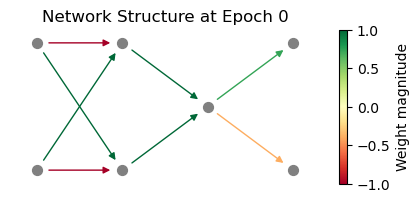

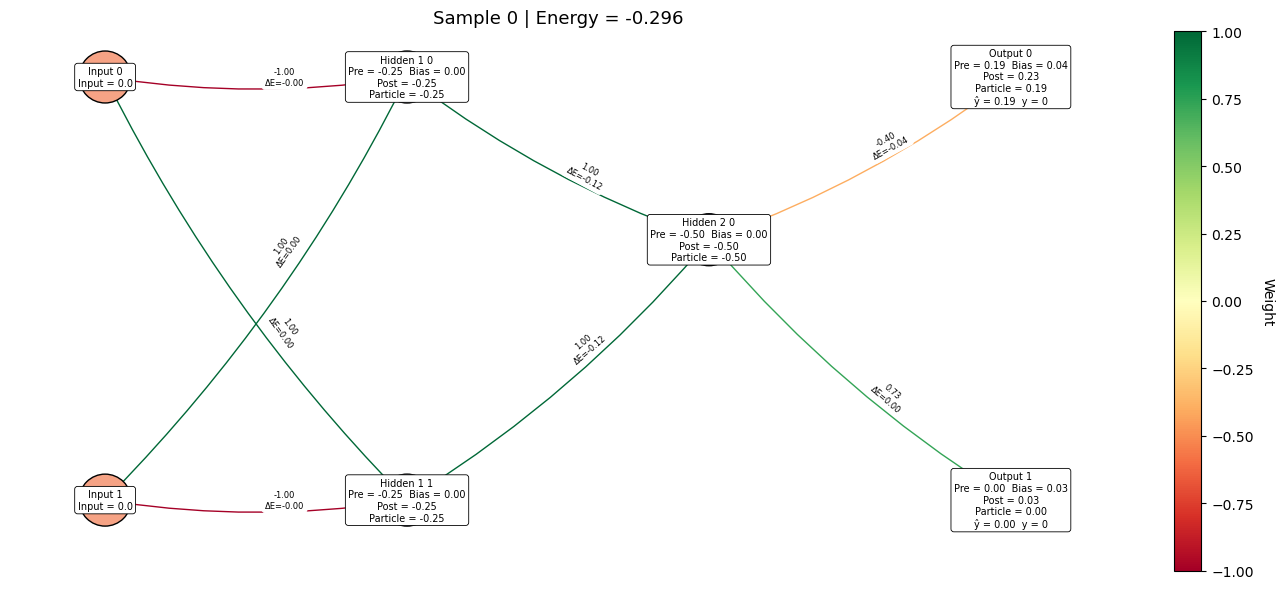

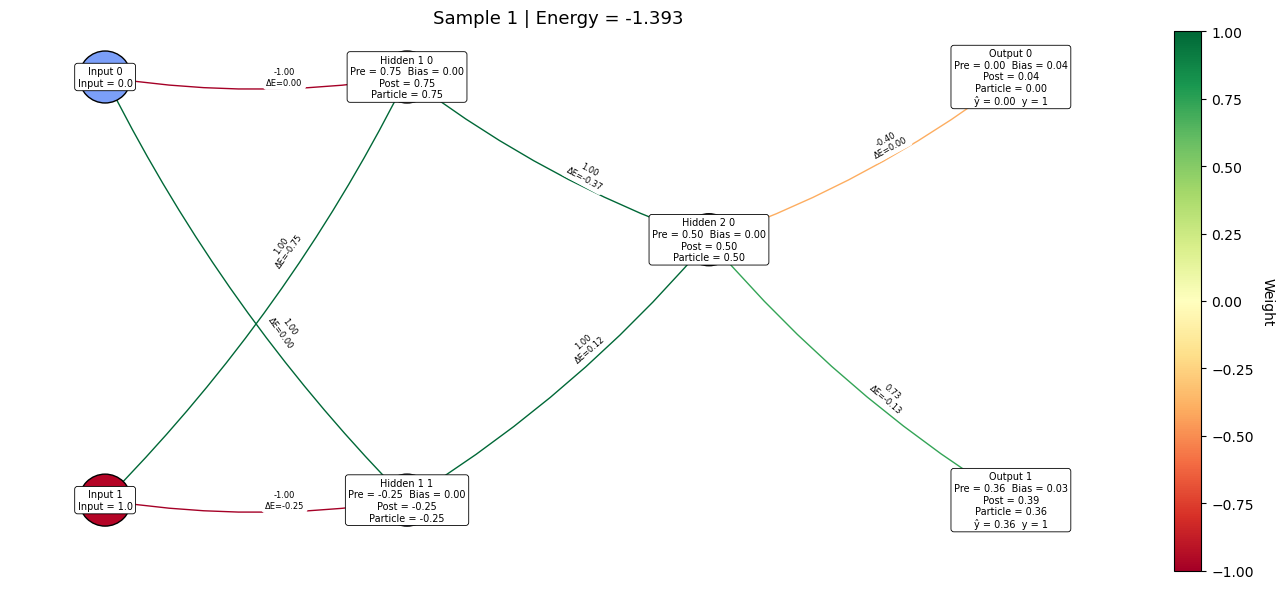

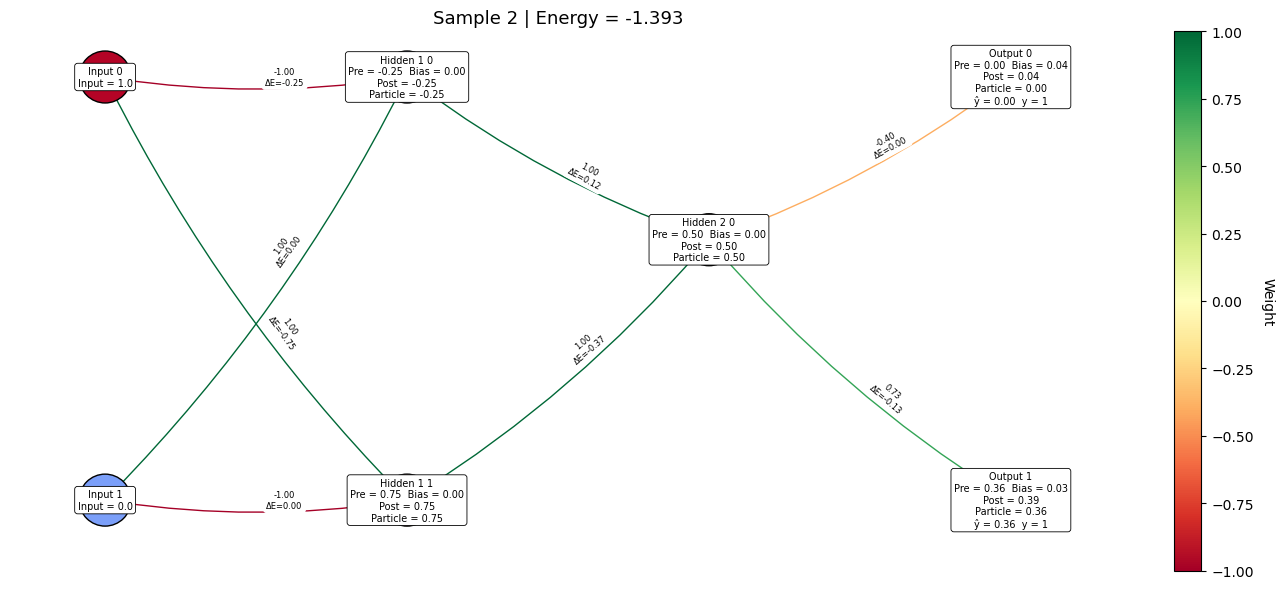

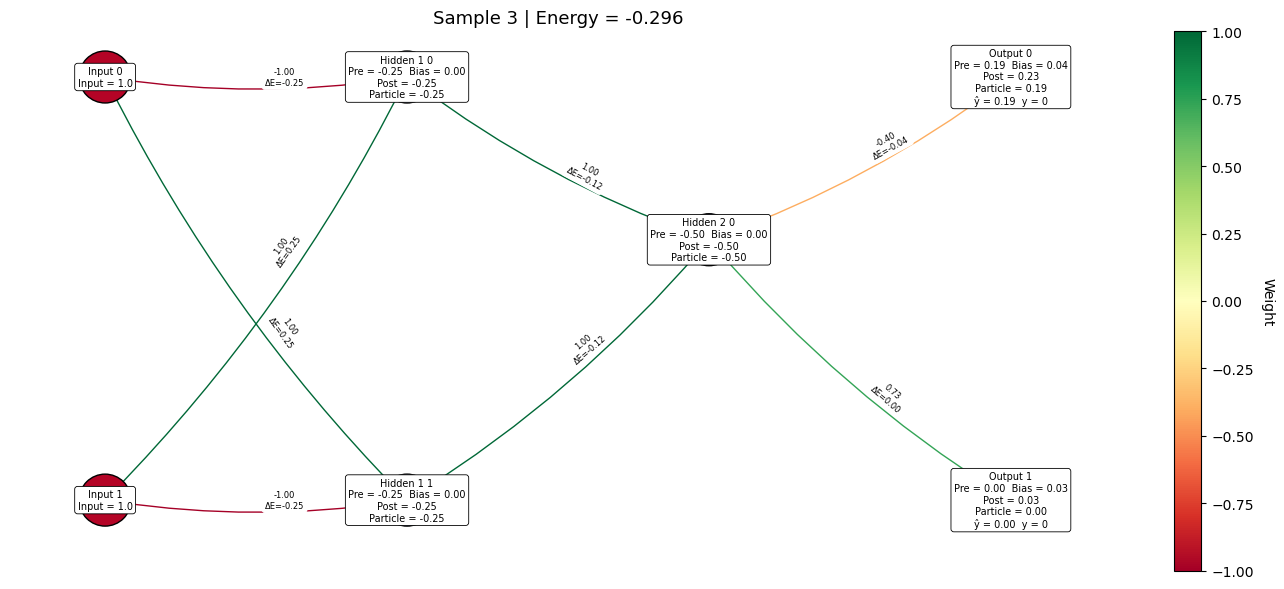

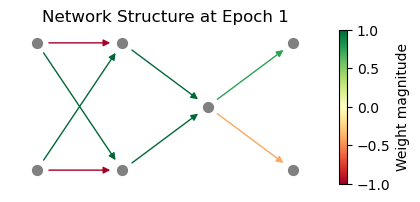

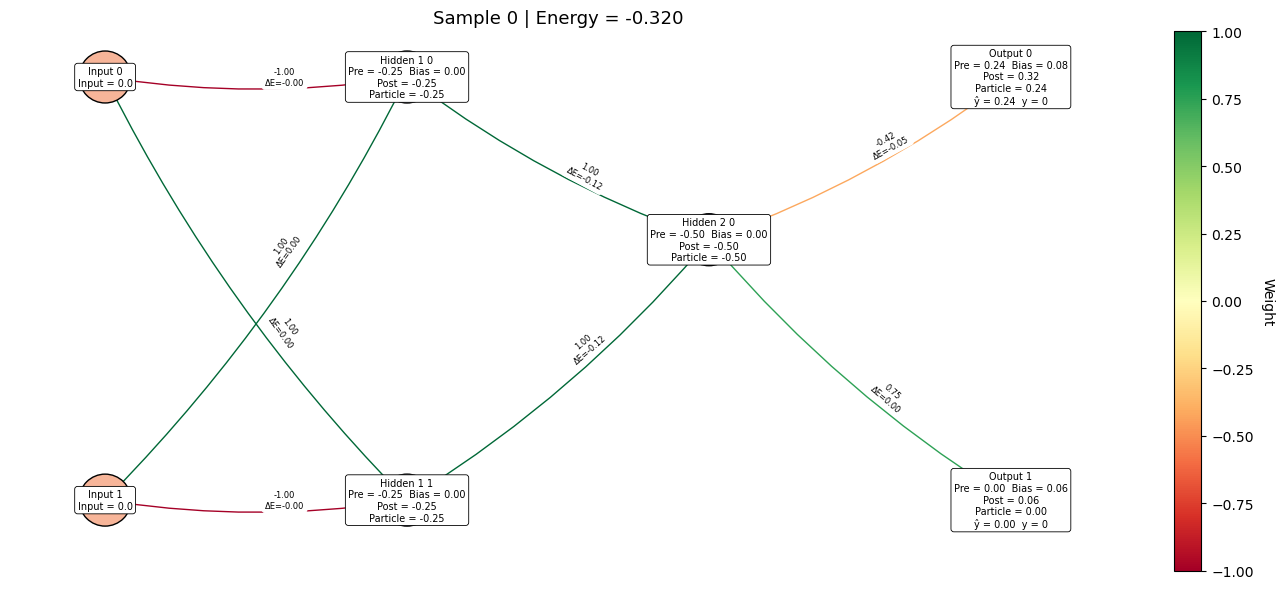

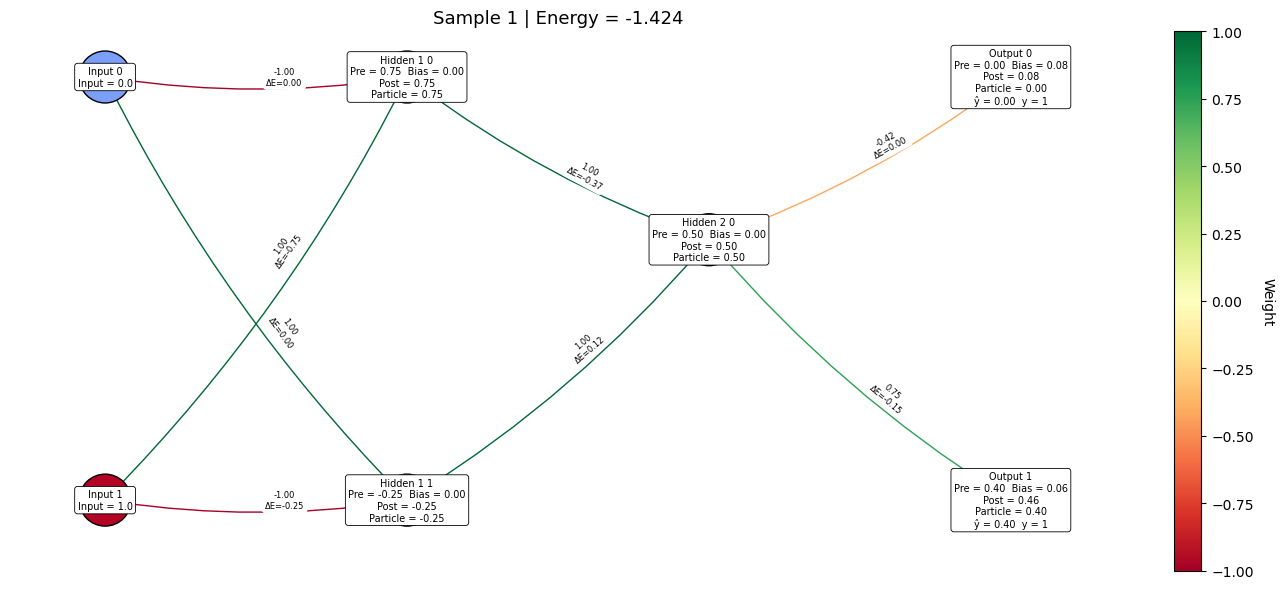

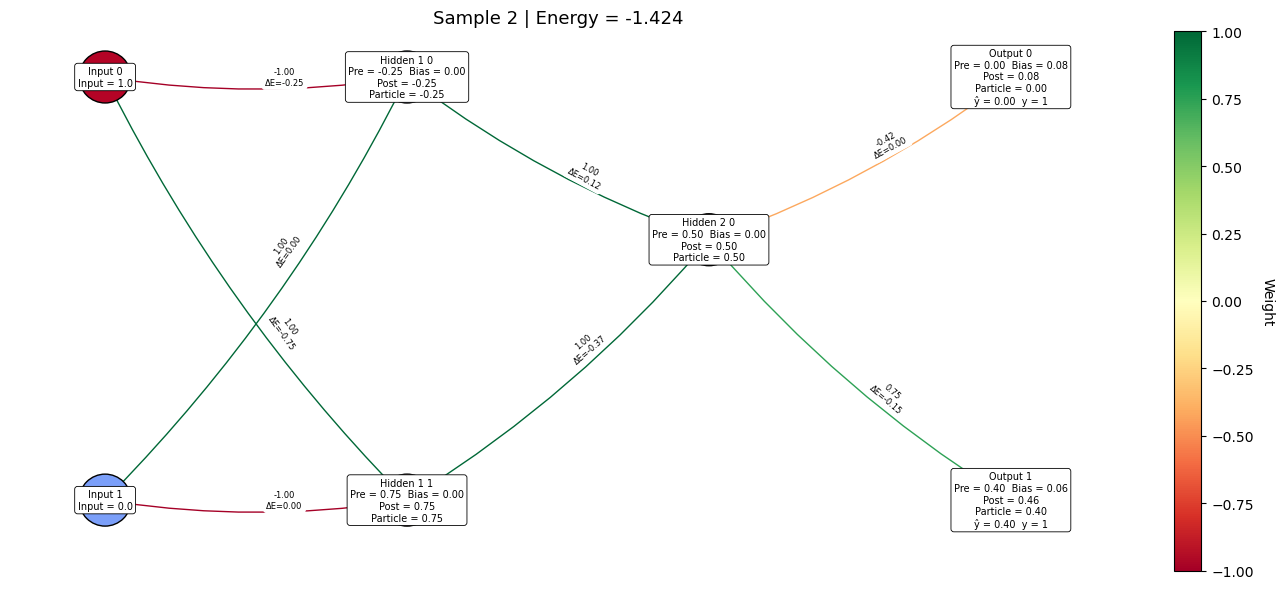

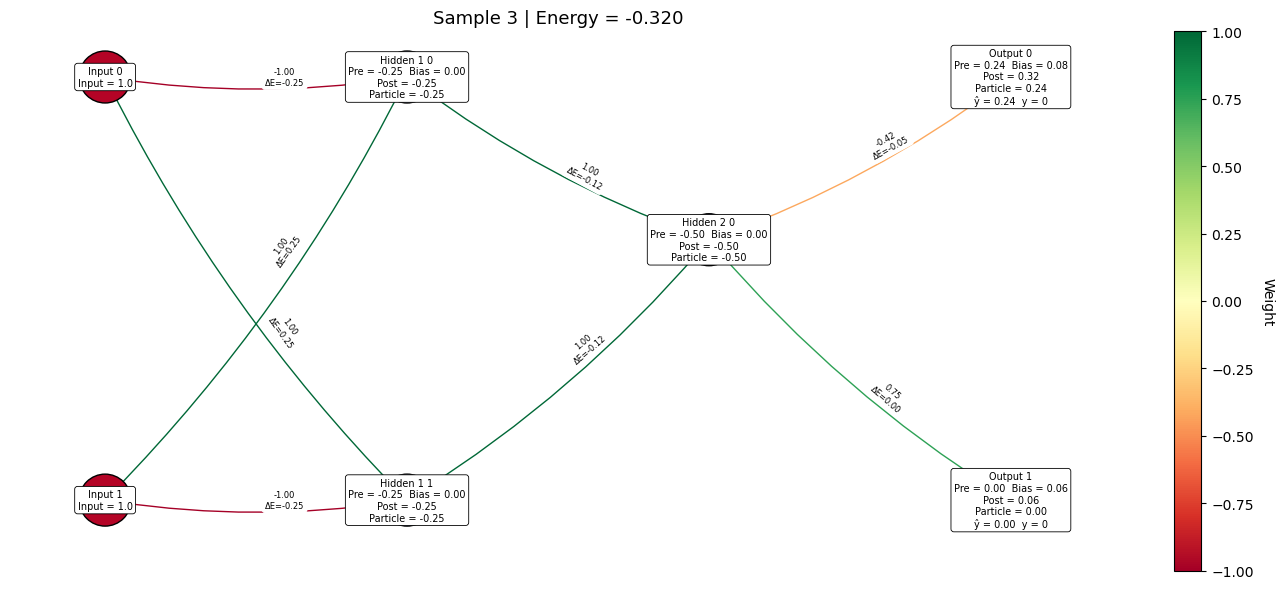

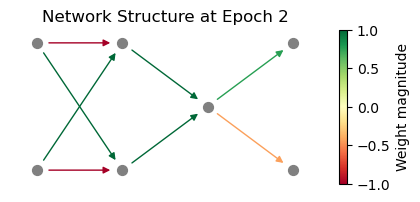

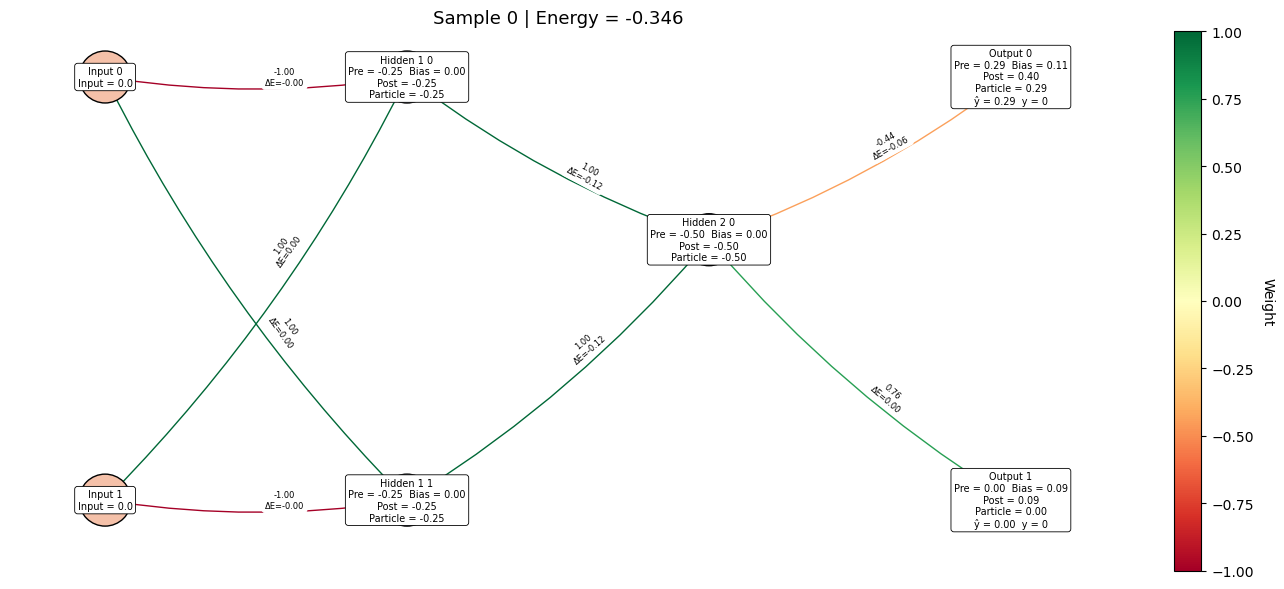

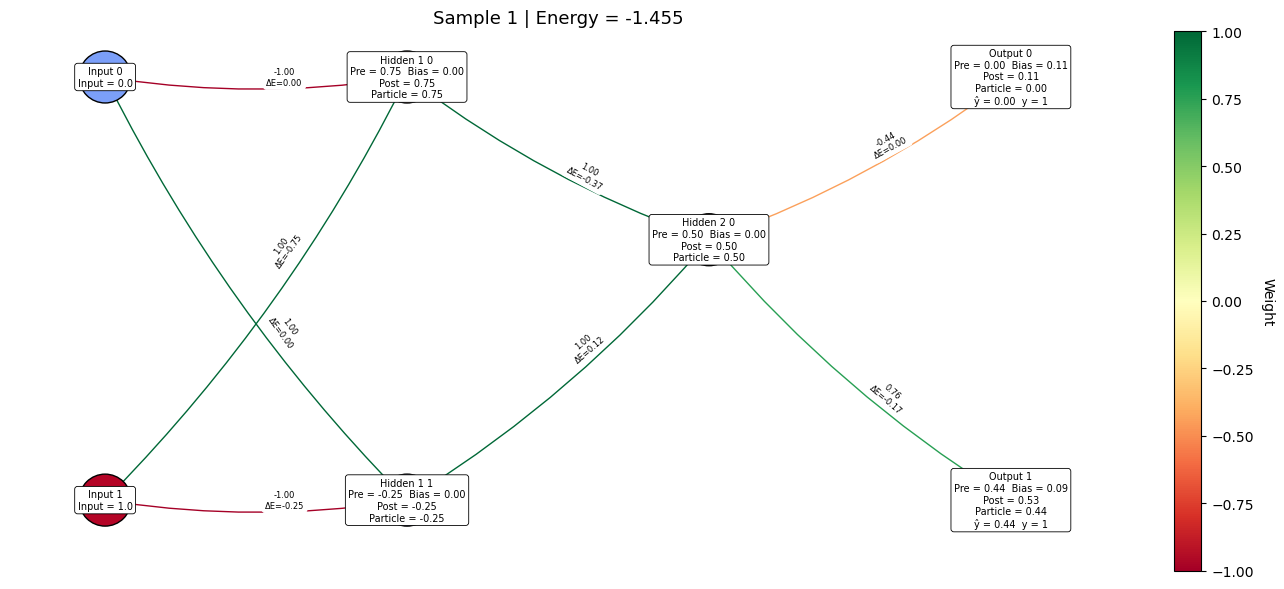

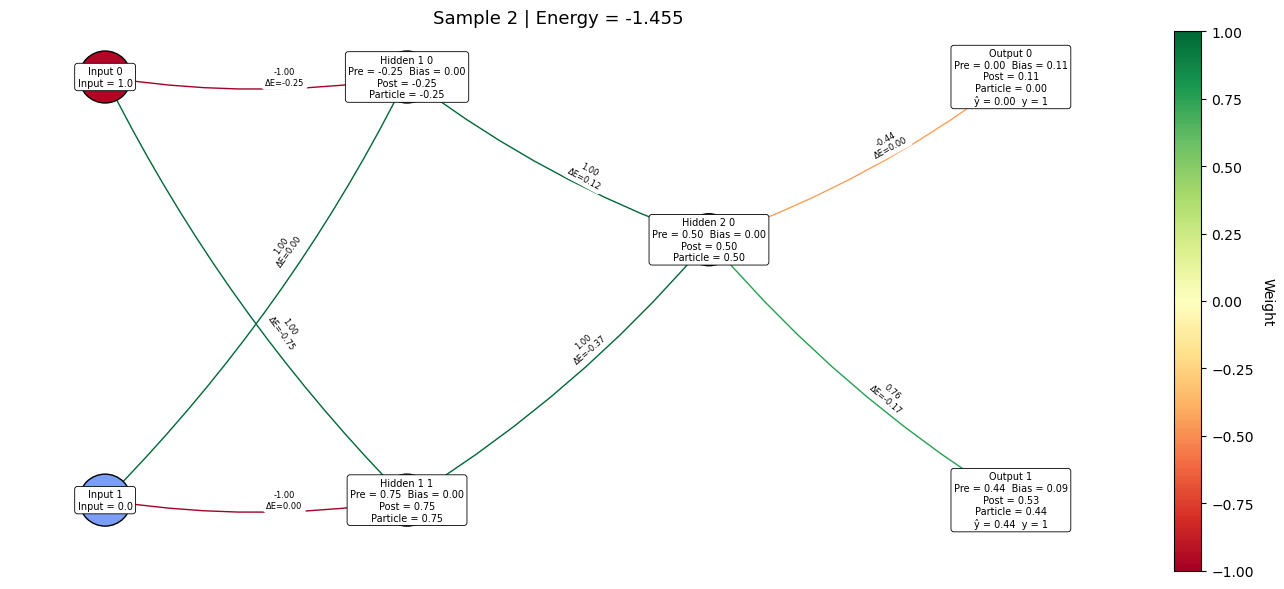

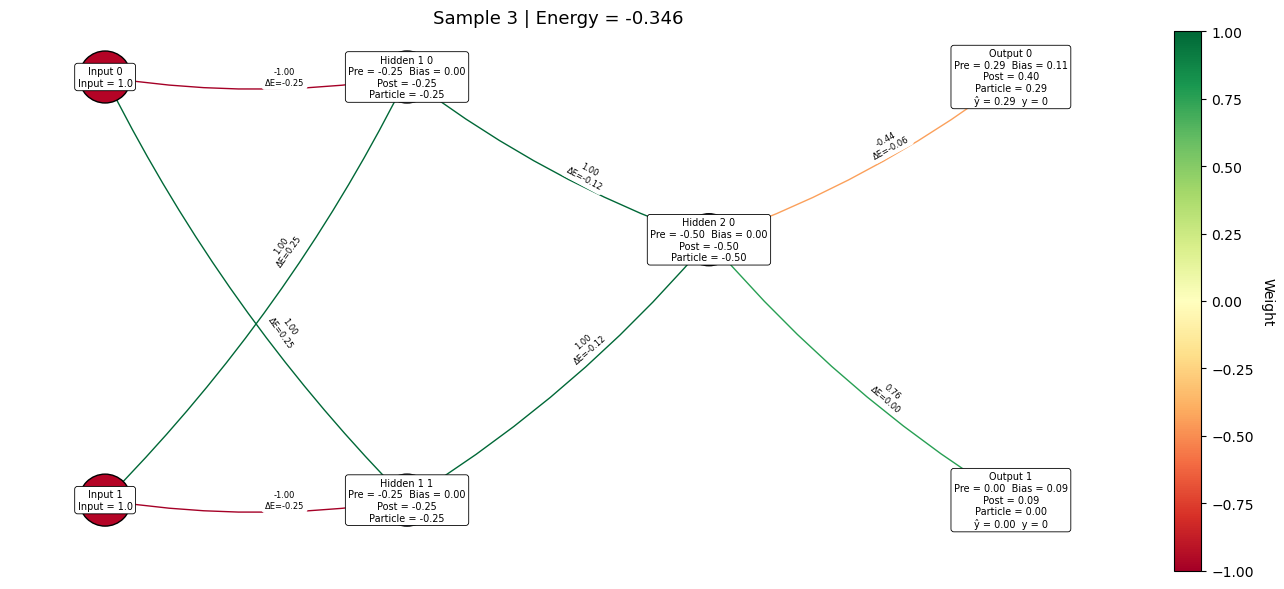

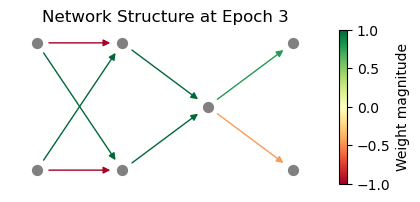

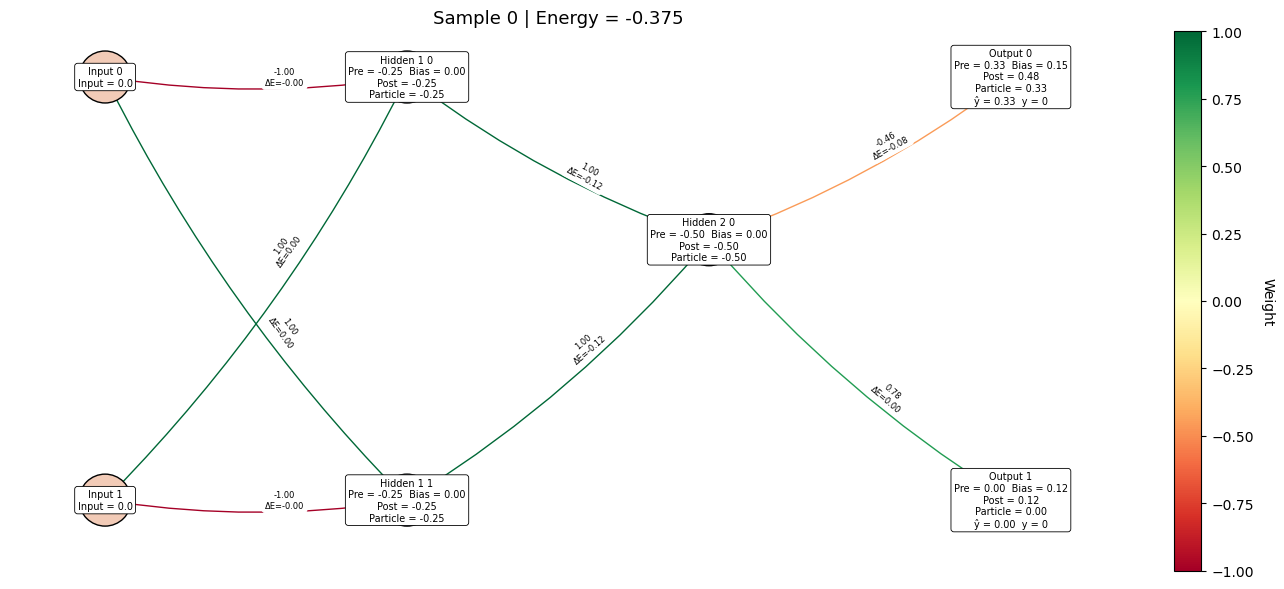

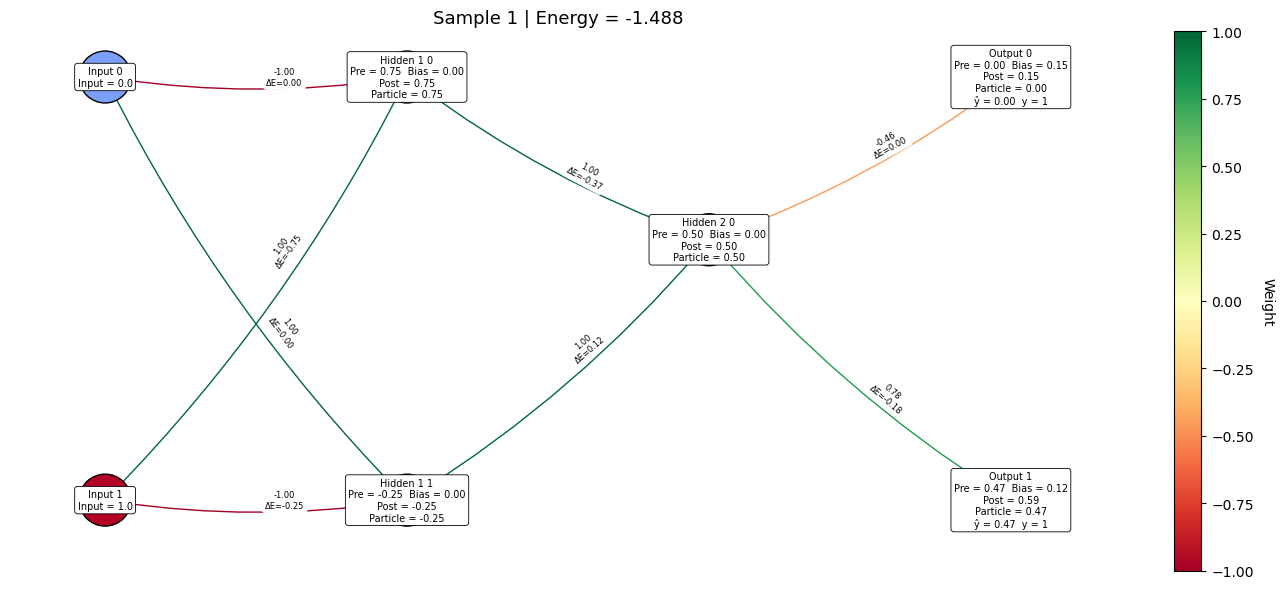

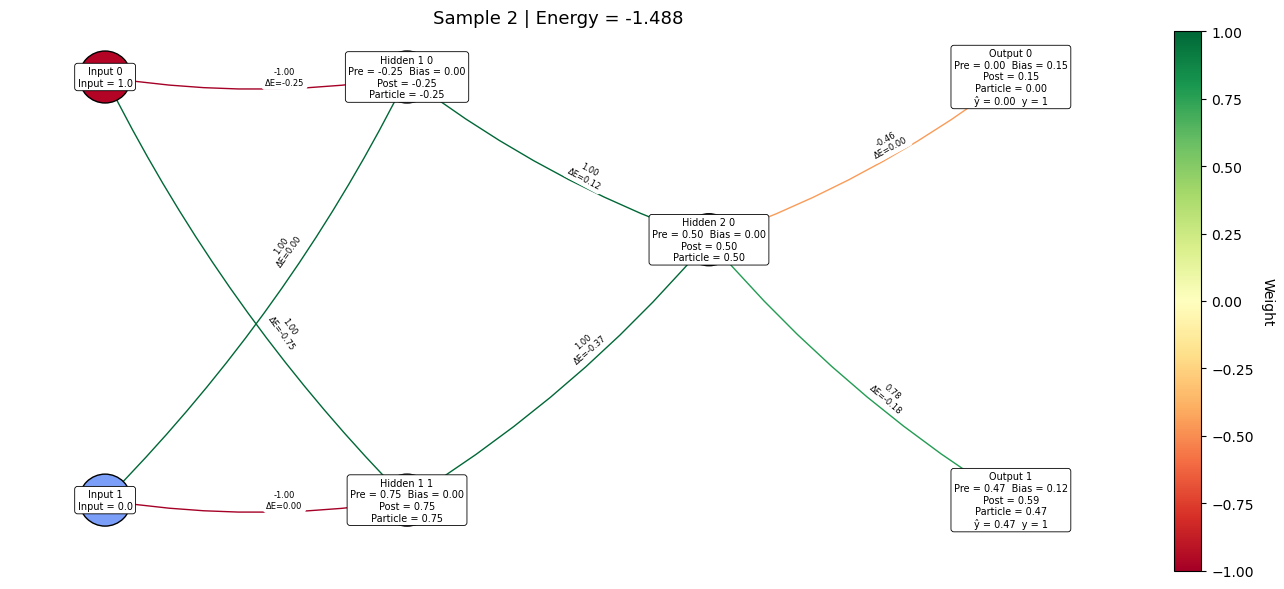

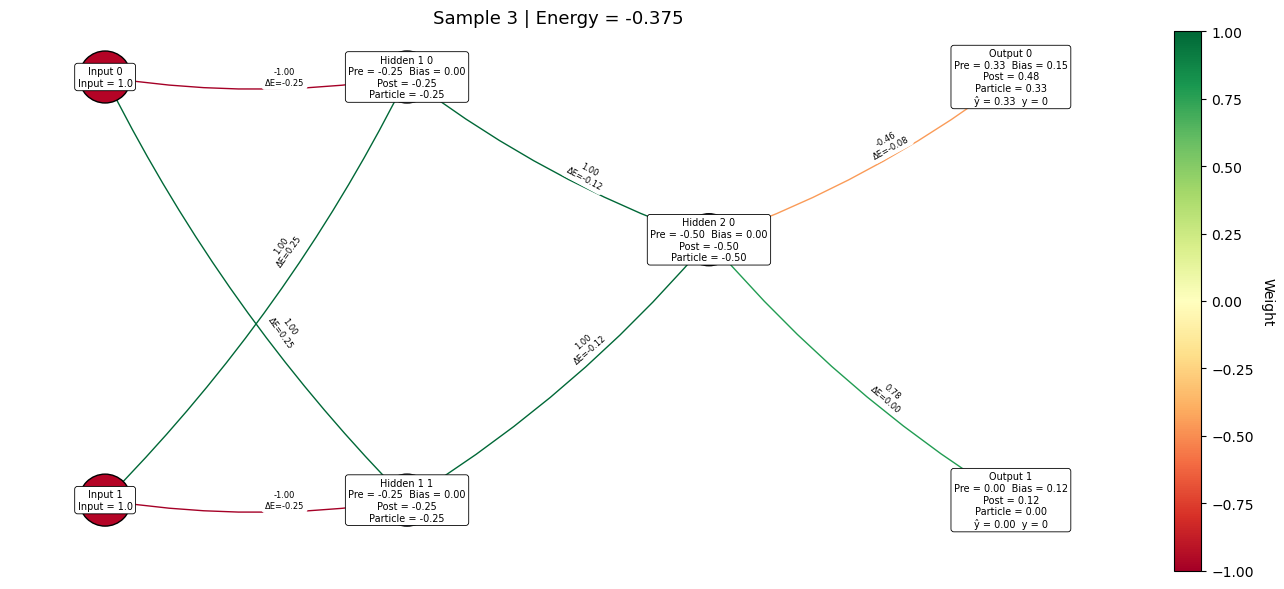

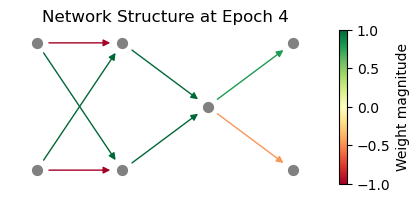

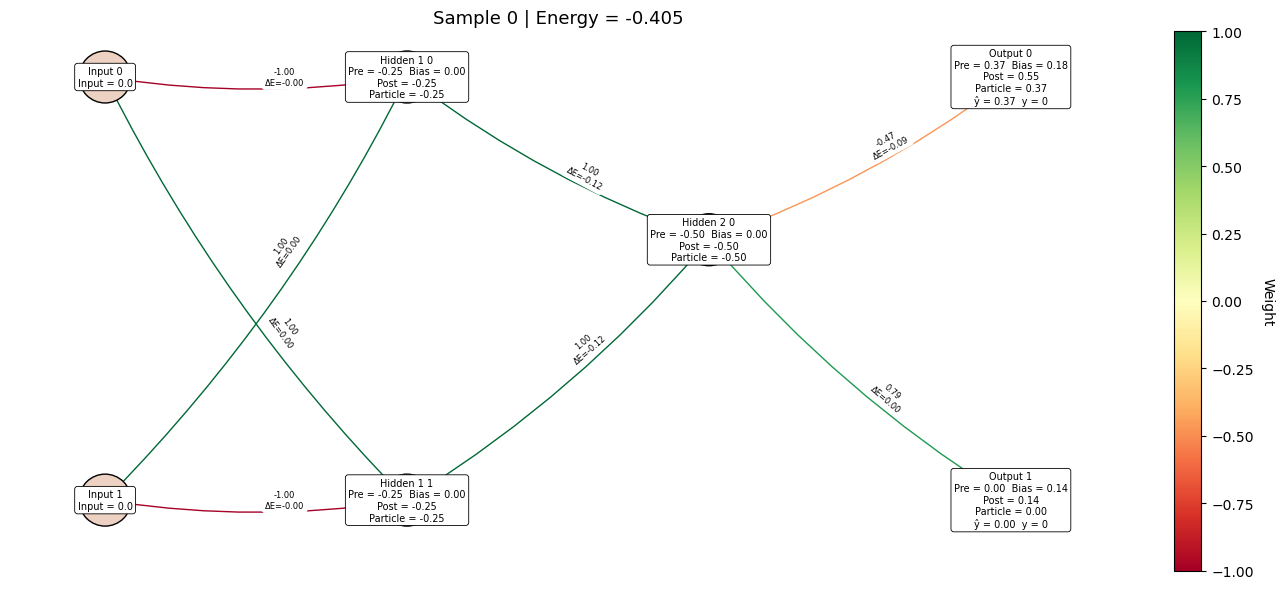

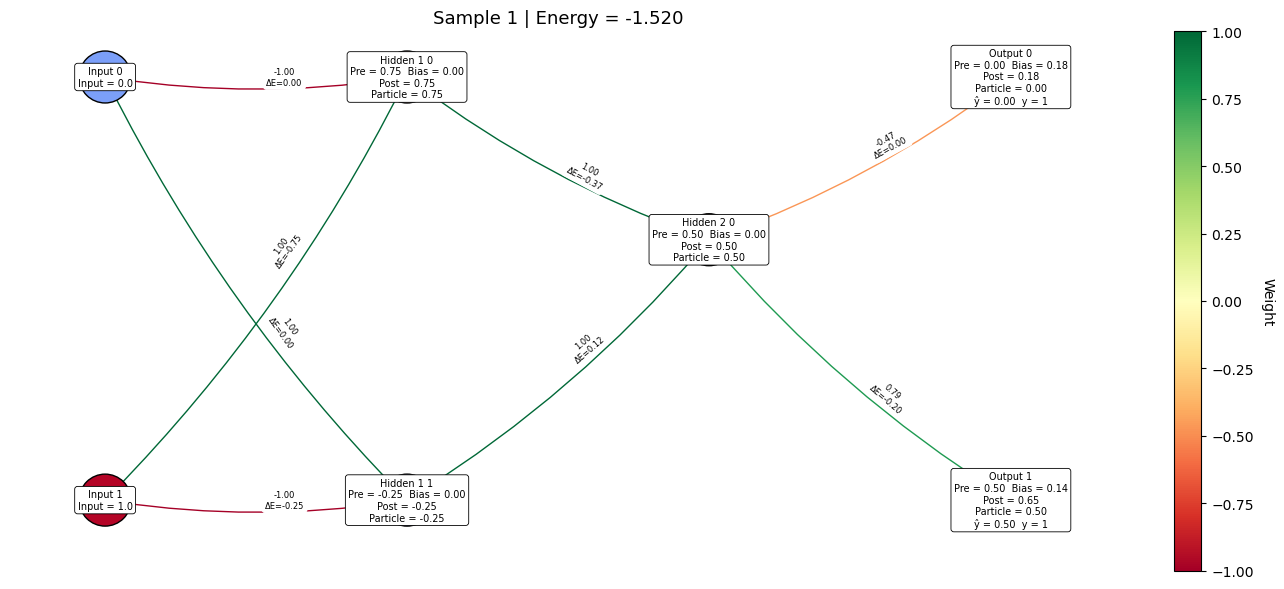

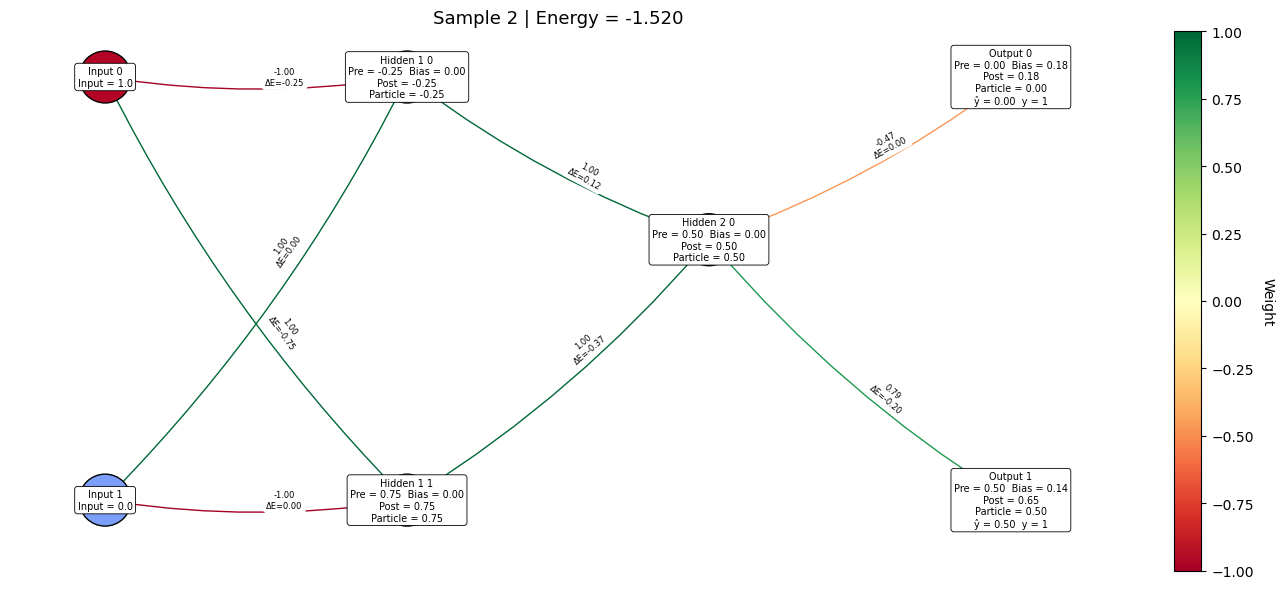

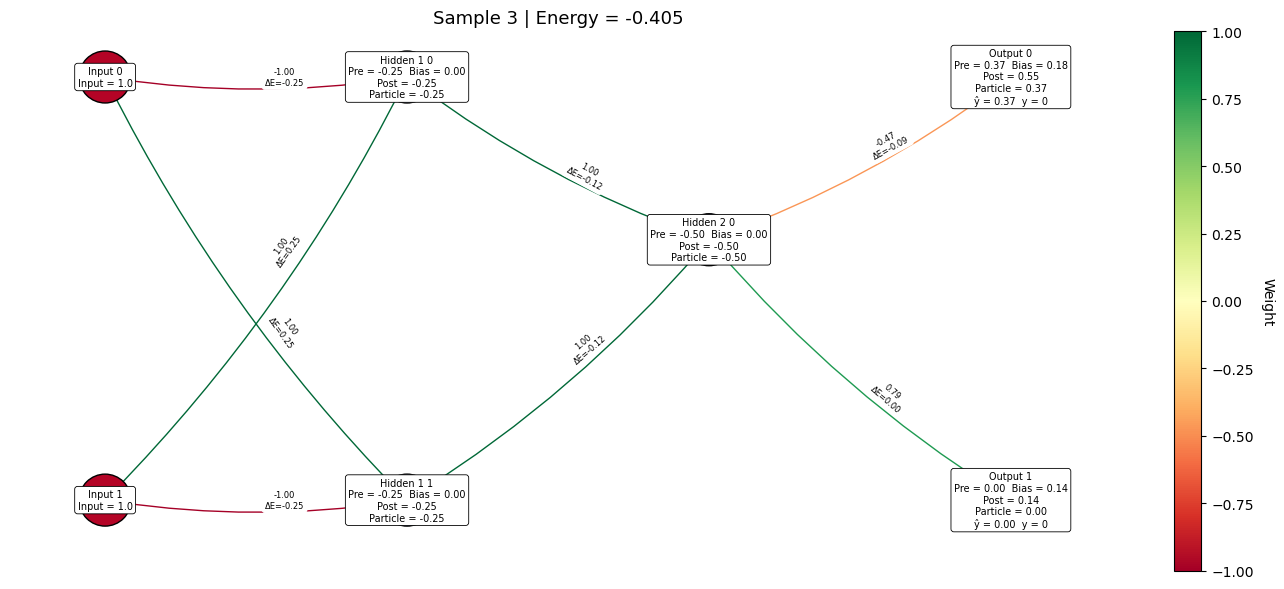

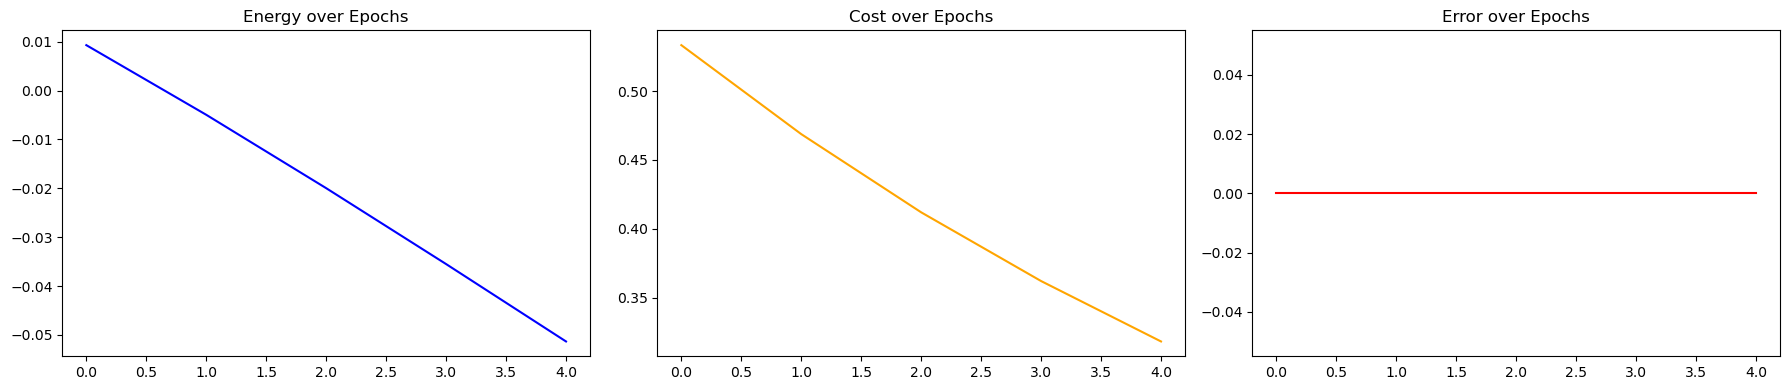

err 0.0
[tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]), tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.3748, 0.0000],
        [0.0000, 0.5043],
        [0.0000, 0.5043],
        [0.3748, 0.0000]])]
[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0.1786, 0.1416])]
[tensor([[-1.,  1.],
        [ 1., -1.]]), tensor([[1.0000],
        [1.0000]]), tensor([[-0.4707,  0.7875]])]
[tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.3748, 0.0000],
        [0.0000, 0.5043],
        [0.0000, 0.5043],
        [0.3748, 0.0000]])]


In [90]:
xor_net = Network(
            name=f"xor_trial_{i}",
            external_world=xor_world,
            hyperparameters={
                "hidden_sizes": [2, 1],
                "output_size": 2,
                "batch_size": 4,
                "n_epochs": 5,  # just test untrained net
                "n_it_neg": 1,
                "n_it_pos": 1,
                "alphas": [0.1,0.1,0.1],
                             "activation": "relu"
            }
        )

        # Unpack init into weights and biases

init = [-1.   ,      1.   ,      1.    ,    -1.     ,    1.0000024 , 1.0000024]
init = torch.tensor(init, dtype=torch.float32)

with torch.no_grad():
    xor_net.weights[0][:] = init[0:4].reshape(2, 2) #torch.tensor([-1, -0.25, 0.25, 1]).reshape(2, 2)
    xor_net.weights[1][:] = init[4:6].reshape(2, 1)# torch.tensor([-1, 1]).reshape(2, 1)


# Evaluate the net — assume this function exists
print('err', train_net(xor_net, plot_graph= True))
# print("Total layer sum:", sum(l.sum() for l in xor_net.layers).item())
# print("Total weight sum:", sum(w.sum() for w in xor_net.weights).item())
# print("Total bias sum:", sum(b.sum() for b in xor_net.biases).item())

print(xor_net.layers)
print(xor_net.biases)
print(xor_net.weights)
print(xor_net.persistent_particles)




[tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]), tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.5000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.5000, 0.0000]])]
[tensor([[-1.0375,  0.0125],
        [ 0.0125, -1.0375]]), tensor([[1.0000],
        [1.0000]]), tensor([[-1.,  1.]])]
[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0., 0.])]


In [ ]:




100: [tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]), tensor([[-0.2498, -0.2498],
        [ 0.7494, -0.2498],
        [-0.2498,  0.7494],
        [-0.2498, -0.2498]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.0000, 0.0000],
        [0.6353, 0.3973],
        [0.6353, 0.3973],
        [0.0000, 0.0000]])]
[tensor([[-1.0375,  0.0125],
        [ 0.0125, -1.0375]]), tensor([[1.0000],
        [1.0000]]), tensor([[-1.,  1.]])]
[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0., 0.])]

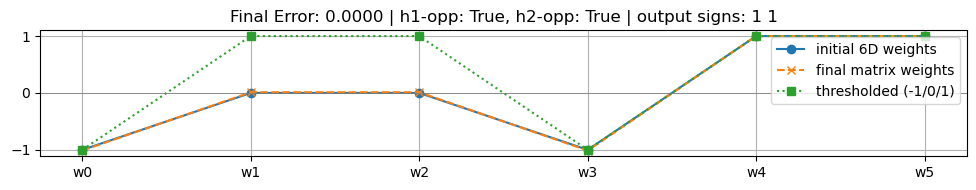

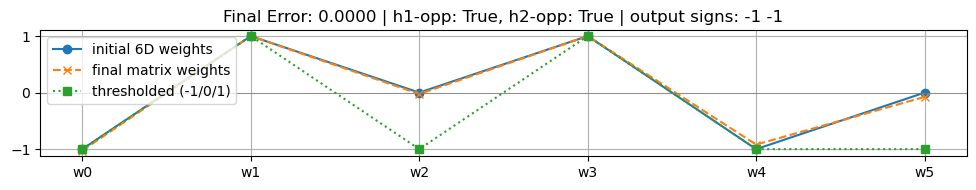

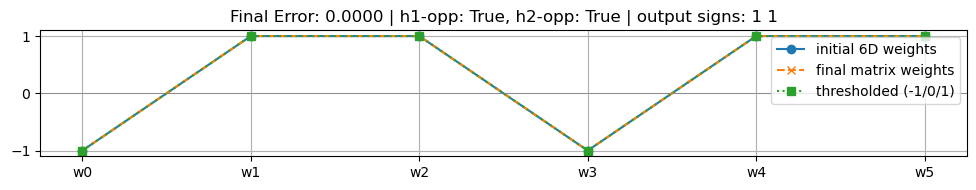

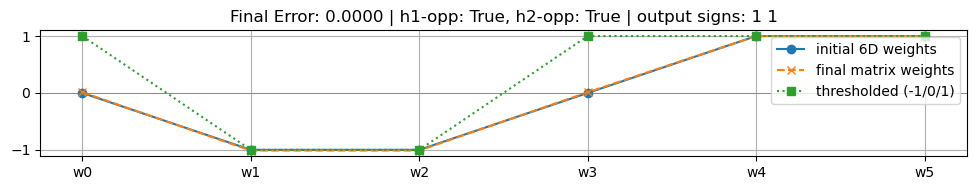

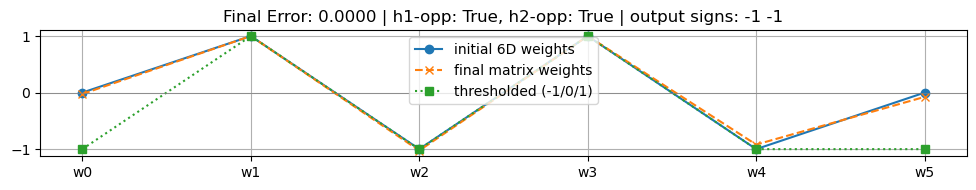

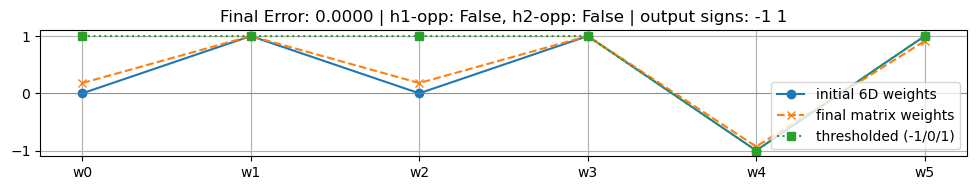

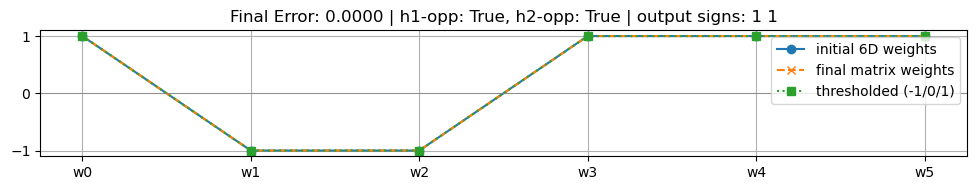

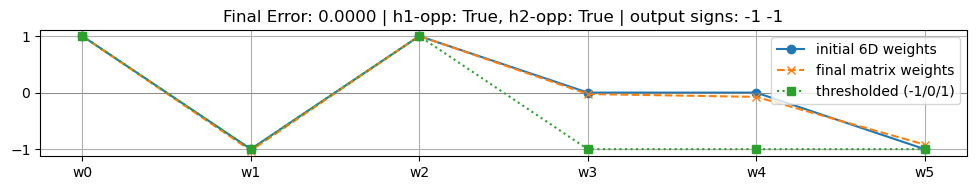

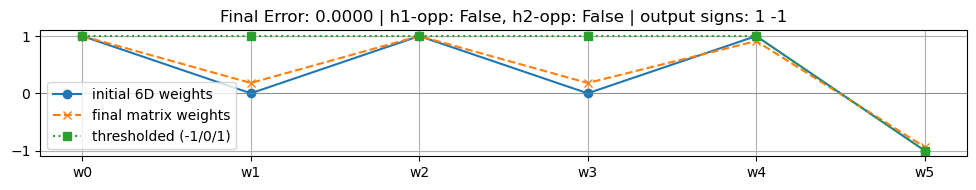

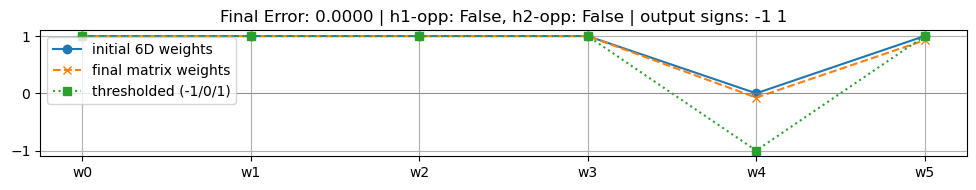

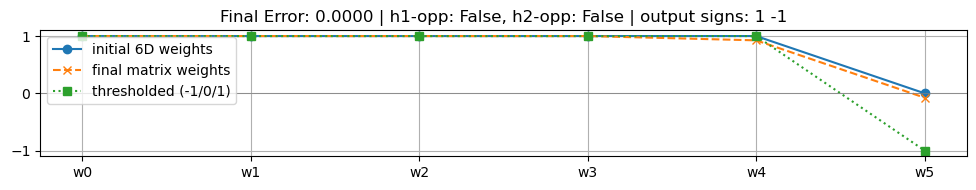

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

for initial_weights, (final_error, w_in, w_out) in [(k, errors[k]) for k in errors if errors[k][0] < 0.001]:
    w_in = w_in.numpy()
    w_out = w_out.numpy()
    
    # Flatten and concatenate final weights
    final_weights = np.concatenate([w_in.flatten(), w_out.flatten()])
    
    # Apply threshold: map to {-1, 0, 1}
    thresholded = np.zeros_like(final_weights)
    thresholded[final_weights > 0.0005] = 1
    thresholded[final_weights < -0.0005] = -1

    # Opposing signs check for each hidden unit
    opp_hidden_1 = np.sign(w_in[0, 0]) != np.sign(w_in[0, 1])
    opp_hidden_2 = np.sign(w_in[1, 0]) != np.sign(w_in[1, 1])

    # Output signs
    output_signs = np.sign(w_out.flatten()).astype(int)
    output_flag = "output signs: " + " ".join(map(str, output_signs))
    pair_flag = f"h1-opp: {opp_hidden_1}, h2-opp: {opp_hidden_2}"

    # Plotting
    plt.figure(figsize=(10, 2))
    plt.plot(initial_weights.numpy(), label="initial 6D weights", marker='o')
    plt.plot(final_weights, label="final matrix weights", linestyle='--', marker='x')
    plt.plot(thresholded, label="thresholded (-1/0/1)", linestyle=':', marker='s')

    plt.title(f"Final Error: {final_error:.4f} | {pair_flag} | {output_flag}")
    plt.xticks(ticks=range(6), labels=[f'w{i}' for i in range(6)])
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt

for item in [(k, errors[k]) for k in errors if errors[k][0] < 0.001]:
    initial_weights = item[0]                # 6D vector
    final_error, w_in, w_out = item[1]

    # Flatten and concatenate hidden & output weights
    final_weights = np.array(torch.cat([w_in.flatten(), w_out.flatten()]))
    
    plt.figure(figsize = (10,1))
    # Plot original 6D vector
    plt.plot(initial_weights.numpy(), label="6D weights")

    # Plot unrolled full matrix weights (optional)
    plt.plot(final_weights.numpy(), label="matrix weights")

    # Print raw values
    # print("Raw tuple:", item)
    # print("Unrolled:", full_matrix_weights.tolist())

    plt.legend()
    plt.show()
    # break  # only first


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

(tensor([-1.,  0.,  0., -1.,  1.,  1.]), (0.0, tensor([[-1.0125,  0.0125],
        [ 0.0125, -1.0125]]), tensor([[1.0000],
        [1.0000]])))
[tensor([-1.0125,  0.0125]), tensor([ 0.0125, -1.0125]), tensor([1.0000]), tensor([1.0000])]


/var/folders/q0/hw11rnjs0g1cnny7p5swsnv40000gn/T/ipykernel_41981/448095749.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


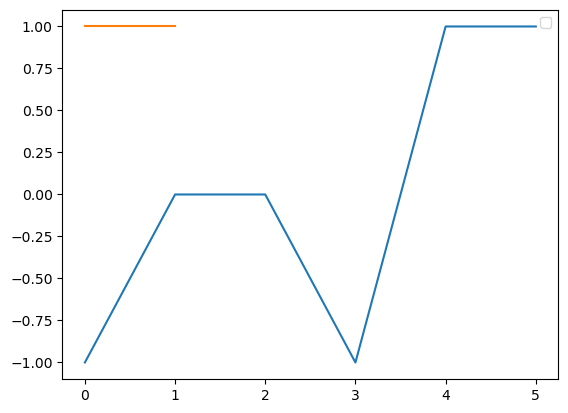

In [ ]:
for item in [(k, errors[k]) for k in errors if errors[k][0] < 0.001]:
    plt.plot(item[0])
    plt.plot(item[1][-1])
    print(item)
    print(list(item[1][-2]) + list(item[1][-1]))
    # print(item[1][0])
    plt.legend()
    plt.show()
    break

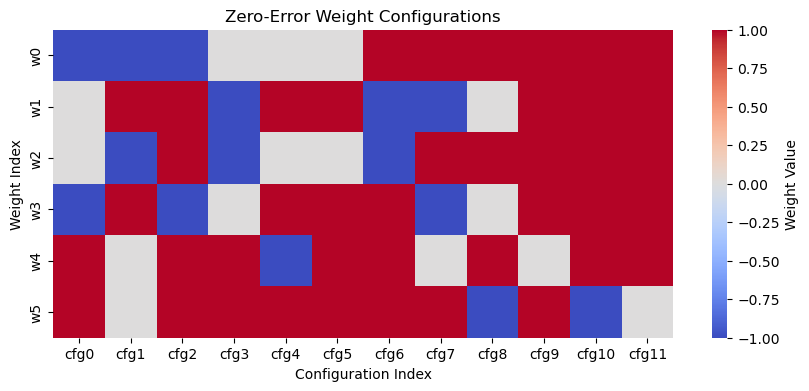

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot as a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(zero_error_weights.T, cmap='coolwarm', center=0,
            xticklabels=[f'cfg{i}' for i in range(zero_error_weights.shape[0])],
            yticklabels=[f'w{i}' for i in range(zero_error_weights.shape[1])],
            cbar_kws={"label": "Weight Value"})
plt.title("Zero-Error Weight Configurations")
plt.xlabel("Configuration Index")
plt.ylabel("Weight Index")
plt.show()


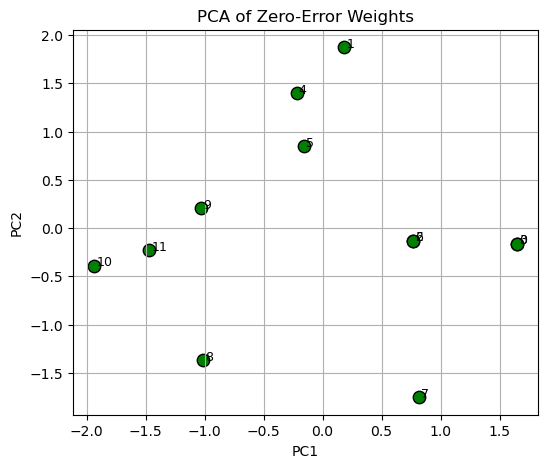

In [ ]:
from sklearn.decomposition import PCA

# Convert to numpy
X = zero_error_weights.numpy()
pca = PCA(n_components=2)
proj = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(proj[:, 0], proj[:, 1], c='green', s=80, edgecolors='black')
for i, (x, y) in enumerate(proj):
    plt.text(x + 0.02, y, str(i), fontsize=9)
plt.title("PCA of Zero-Error Weights")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


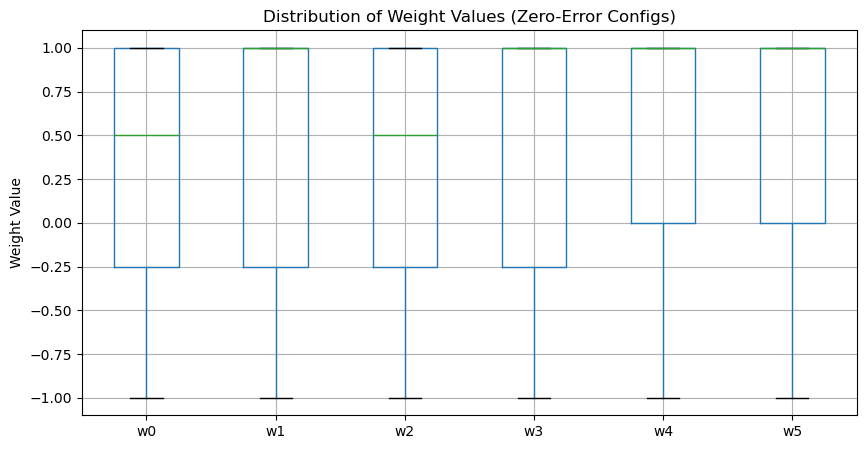

In [ ]:
import pandas as pd

df = pd.DataFrame(zero_error_weights.numpy(), columns=[f'w{i}' for i in range(6)])
plt.figure(figsize=(10, 5))
df.boxplot()
plt.title("Distribution of Weight Values (Zero-Error Configs)")
plt.ylabel("Weight Value")
plt.grid(True)
plt.show()


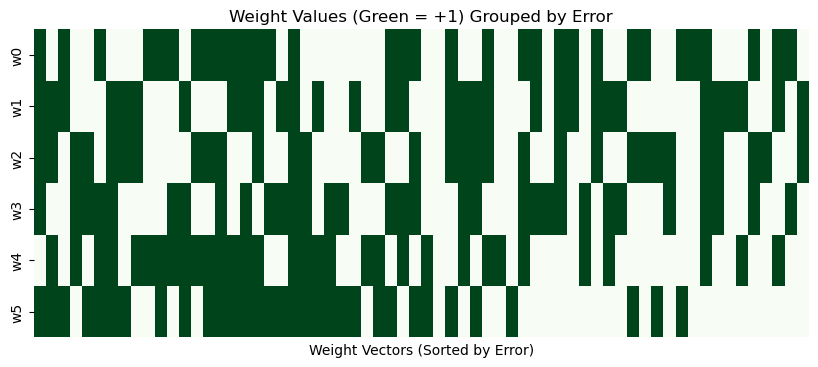

In [ ]:
import seaborn as sns

# Create DataFrame for heatmap
df_bin = pd.DataFrame(initial_weights, columns=[f'w{i}' for i in range(6)])
df_bin['error'] = errors
df_bin['error_label'] = df_bin['error'].astype(str)

# Sort by error
df_bin_sorted = df_bin.sort_values('error')
heat_data = df_bin_sorted.drop(columns=['error', 'error_label'])

plt.figure(figsize=(10, 4))
sns.heatmap((heat_data == 1).T, cmap='Greens', cbar=False, xticklabels=False)
plt.yticks(np.arange(6)+0.5, heat_data.columns)
plt.title("Weight Values (Green = +1) Grouped by Error")
plt.xlabel("Weight Vectors (Sorted by Error)")
plt.show()


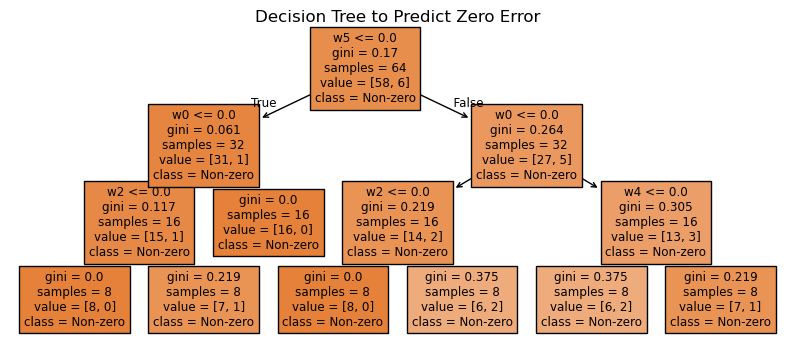

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

X = initial_weights
y = (errors <=0.1).astype(int)  # binary target: 1 if error == 0

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

plt.figure(figsize=(10, 4))
plot_tree(clf, feature_names=[f'w{i}' for i in range(6)], class_names=["Non-zero", "Zero"], filled=True)
plt.title("Decision Tree to Predict Zero Error")
plt.show()


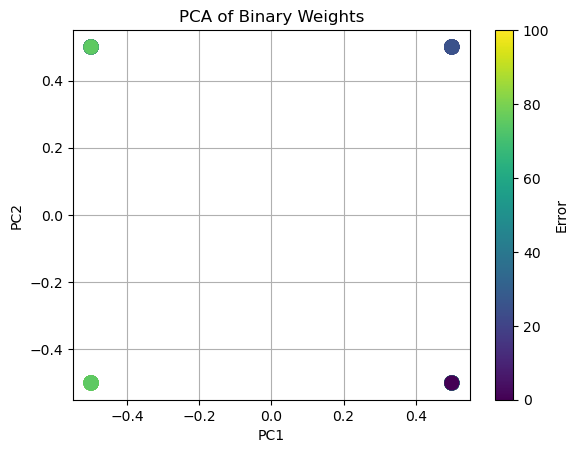

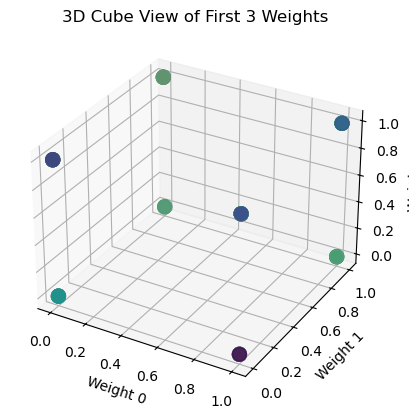

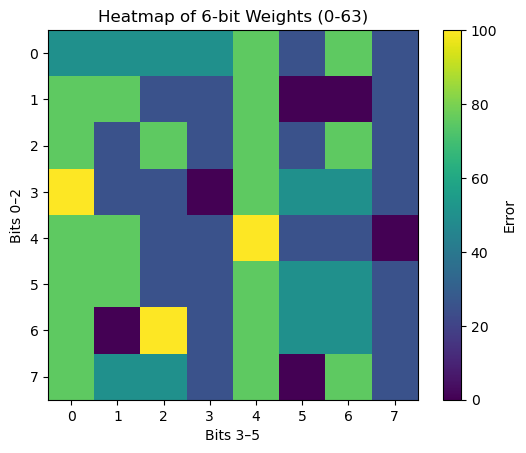

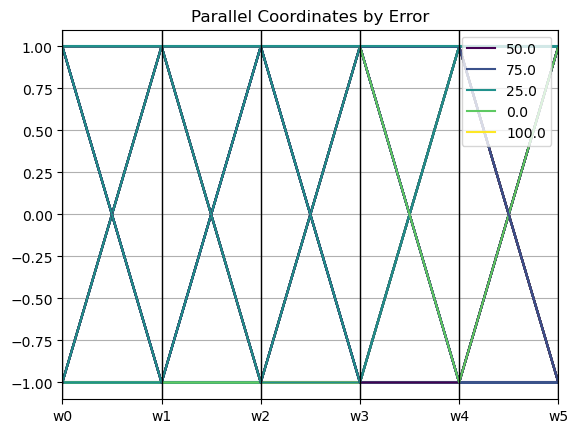

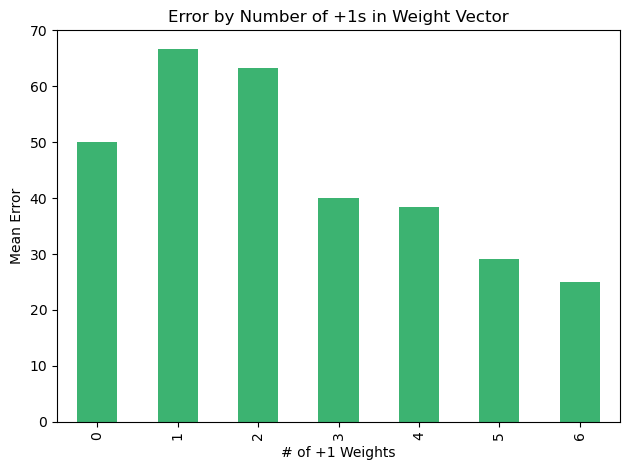

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from pandas.plotting import parallel_coordinates
from mpl_toolkits.mplot3d import Axes3D

# XOR binary weights to final error
raw_data = errors 
initial_weights = np.array(list(raw_data.keys()))
errors = np.array(list(raw_data.values()))
binary = ((initial_weights + 1) / 2).astype(int)

# 1. PCA Plot
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(binary)

plt.figure()
plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=errors, cmap='viridis', s=100)
plt.colorbar(label='Error')
plt.title('PCA of Binary Weights')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

# 2. 3D Projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(binary[:, 0], binary[:, 1], binary[:, 2], c=errors, cmap='viridis', s=100)
ax.set_xlabel('Weight 0')
ax.set_ylabel('Weight 1')
ax.set_zlabel('Weight 2')
plt.title('3D Cube View of First 3 Weights')

# 3. Heatmap of All 64 Configs
heatmap = np.full((64,), np.nan)
for i, b in enumerate(binary):
    idx = int("".join(b.astype(str)), 2)
    heatmap[idx] = errors[i]
heatmap_reshaped = heatmap.reshape(8, 8)

plt.figure()
plt.imshow(heatmap_reshaped, cmap='viridis', vmin=0, vmax=100)
plt.colorbar(label='Error')
plt.title('Heatmap of 6-bit Weights (0-63)')
plt.xlabel('Bits 3–5')
plt.ylabel('Bits 0–2')

# 4. Parallel Coordinates
df = pd.DataFrame(initial_weights, columns=[f'w{i}' for i in range(6)])
df['error'] = errors
plt.figure()
parallel_coordinates(df, 'error', colormap='viridis')
plt.title("Parallel Coordinates by Error")

# 5. Histogram by # of +1 Weights
num_pos_ones = (initial_weights == 1).sum(axis=1)
df_hist = pd.DataFrame({'num_pos_ones': num_pos_ones, 'error': errors})
mean_errors = df_hist.groupby('num_pos_ones')['error'].mean()

plt.figure()
mean_errors.plot(kind='bar', color='mediumseagreen')
plt.xlabel('# of +1 Weights')
plt.ylabel('Mean Error')
plt.title('Error by Number of +1s in Weight Vector')

plt.tight_layout()
plt.show()
